**FEEL FREE TO UPVOTE**  （＾ｖ＾）

In [1]:
#v20提交成绩得到了3.688， cv 成绩3.6519
#使用authorized_flag 进行特征分别处理,收到了奇效
#使用countVectorizer 对类别变量进行编码，内存存在压力

In [1]:
import numpy as np
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import warnings
import time
warnings.filterwarnings('ignore')
np.random.seed(4950)

In [7]:
from sklearn.model_selection import train_test_split

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
# you need to obtain Wang's features from his notebook
train_all = pd.read_csv('df_train_2_extra.csv')
test = pd.read_csv('df_test_2_extra.csv')
# df_train=pd.read_csv("train_wang_pur_date_4.csv")
# df_test=pd.read_csv("test_wang_pur_date_4.csv")

In [4]:
target_with_outlier=train_all[['outliers','target']]

In [14]:
df_train, df_test, y_train, y_test = train_test_split(train_all, target_with_outlier, test_size=0.1, random_state=10)

In [15]:
df_train['outliers'].sum()/df_train['outliers'].shape[0],df_test['outliers'].sum()/df_test.shape[0]

(0.010978126289723483, 0.010499207606973059)

In [16]:
# Select relevant features
exclude_features = []
exclude_features += ['card_id', 'first_active_month','target','outliers']
df_train_columns = [c for c in df_train.columns if c not in exclude_features ]
target = df_train['target']
#del df_train['target']

In [17]:
len(df_train_columns)
len(exclude_features)

4

### Below part is based on : 
https://www.kaggle.com/ogrellier/feature-selection-with-null-importances

In [18]:
def get_feature_importances(data, shuffle, seed=None):
    # Gather real features
    #train_features = [f for f in data if f not in ['TARGET', 'SK_ID_CURR']]
    # Go over fold and keep track of CV score (train and valid) and feature importances
    
    # Shuffle target if required
    y = data['target'].copy()
    if shuffle:
        # Here you could as well use a binomial distribution
        y = data['target'].copy().sample(frac=1.0)
    
    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    dtrain = lgb.Dataset(data.loc[:,df_train_columns], y, free_raw_data=False, silent=True)
    lgb_params = {'num_leaves': 31,
         'min_data_in_leaf': 32, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 42,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950,
         "device" : "gpu"}
    
    # Fit the model
    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200)

    #num_round = 1000
    #clf = lgb.train(lgb_params, dtrain, num_round, verbose_eval=100)
    #oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    #clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    #oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(df_train_columns)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    #imp_df['trn_score'] = roc_auc_score(y, clf.predict(data[train_features]))
    imp_df['trn_score']=np.sqrt(mean_squared_error(y, clf.predict(data.loc[:,df_train_columns])))
    
    return imp_df


In [19]:
# Seed the unexpected randomness of this world
np.random.seed(123)
# Get the actual importance, i.e. without shuffling
actual_imp_df = get_feature_importances(data=df_train, shuffle=False)

In [20]:
actual_imp_df.sort_values('importance_split',ascending=False).head()


,feature,importance_gain,importance_split,trn_score
225,new_hist_purchase_date_uptonow,1.087222e+06,258,3.571364
62,auth_hist_month_nunique,1.104824e+06,229,3.571364
181,new_hist_purchase_amount_max,6.636879e+05,176,3.571364
91,auth_hist_month_diff_mean,1.055257e+06,151,3.571364
196,new_hist_month_lag_mean,3.915207e+05,144,3.571364


In [21]:
actual_imp_df1=actual_imp_df.copy()

In [22]:
actual_imp_df.sort_values('importance_split',ascending=False).head()

,feature,importance_gain,importance_split,trn_score
225,new_hist_purchase_date_uptonow,1.087222e+06,258,3.571364
62,auth_hist_month_nunique,1.104824e+06,229,3.571364
181,new_hist_purchase_amount_max,6.636879e+05,176,3.571364
91,auth_hist_month_diff_mean,1.055257e+06,151,3.571364
196,new_hist_month_lag_mean,3.915207e+05,144,3.571364


In [23]:
actual_imp_df.sort_values('importance_split',ascending=False).head()

,feature,importance_gain,importance_split,trn_score
225,new_hist_purchase_date_uptonow,1.087222e+06,258,3.571364
62,auth_hist_month_nunique,1.104824e+06,229,3.571364
181,new_hist_purchase_amount_max,6.636879e+05,176,3.571364
91,auth_hist_month_diff_mean,1.055257e+06,151,3.571364
196,new_hist_month_lag_mean,3.915207e+05,144,3.571364


In [24]:
import time

In [25]:
null_imp_df = pd.DataFrame()
nb_runs = 80
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=df_train, shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

Done with   80 of   80 (Spent  13.9 min)

In [26]:
# Save importances just in case
null_imp_df.to_csv('null_importances_distribution_ref_2_extra_test10.csv')
actual_imp_df.to_csv('actual_importances_ditribution_ref_2extra_test10.csv')

In [18]:
#actual_imp_df=feature_importance

In [19]:
# null_imp_df=pd.read_csv('null_importances_distribution_rf.csv')

Score features
There are several ways to score features :

Compute the number of samples in the actual importances that are away from the null importances recorded distribution.
Compute ratios like Actual / Null Max, Actual / Null Mean, Actual Mean / Null Max
In a first step I will use the log actual feature importance divided by the 75 percentile of null distribution.

In [27]:
import matplotlib.gridspec as gridspec
import seaborn as sns

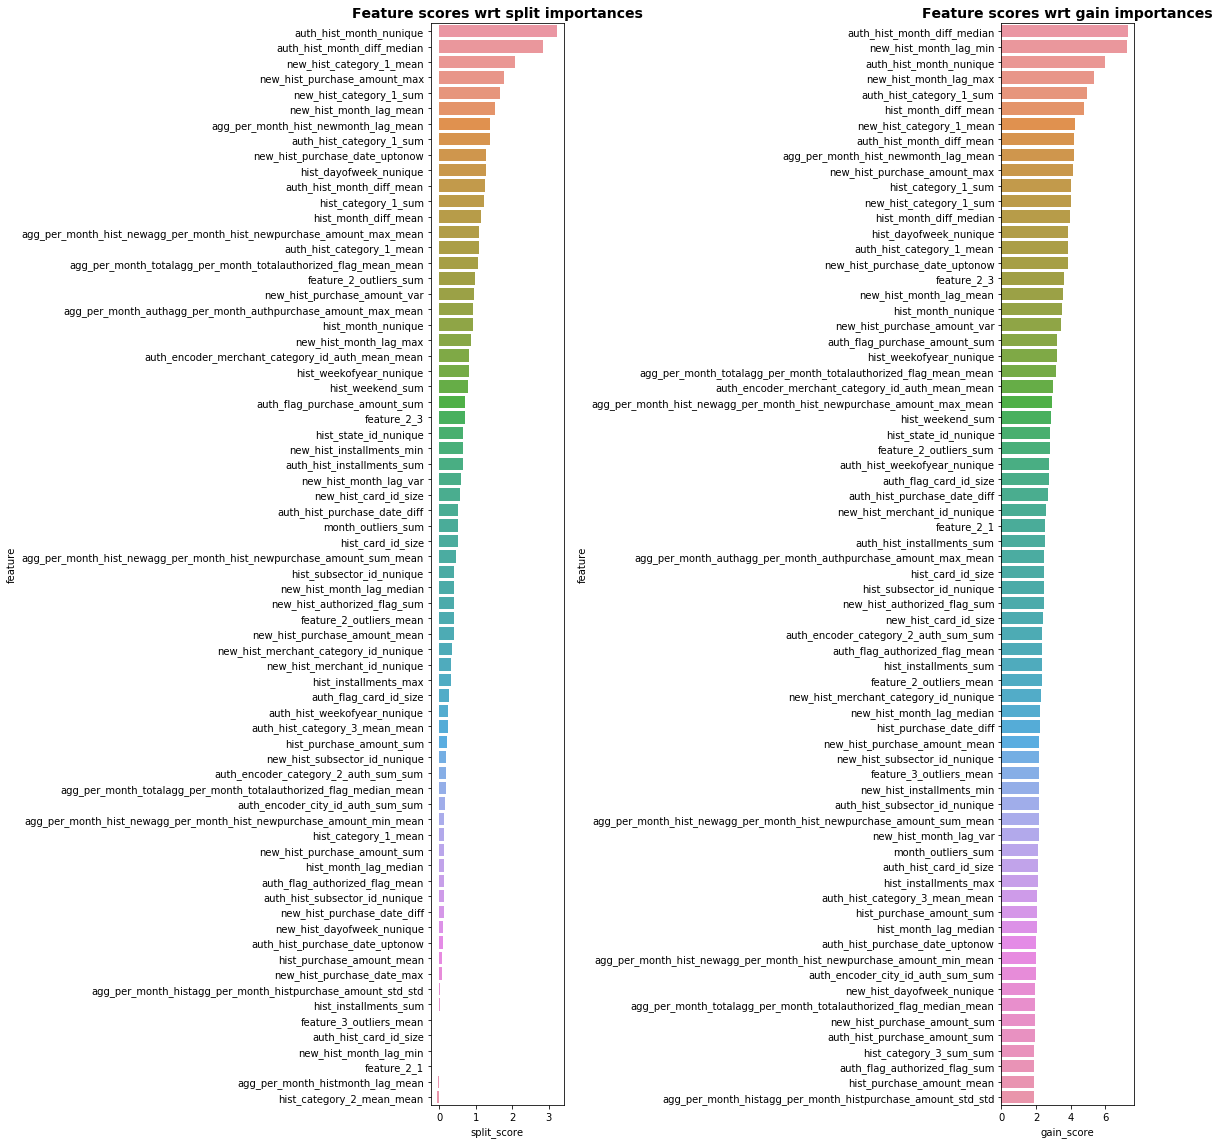

In [28]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()

Check the impact of removing uncorrelated features
Here I'll use a different metric to asses correlation to the target

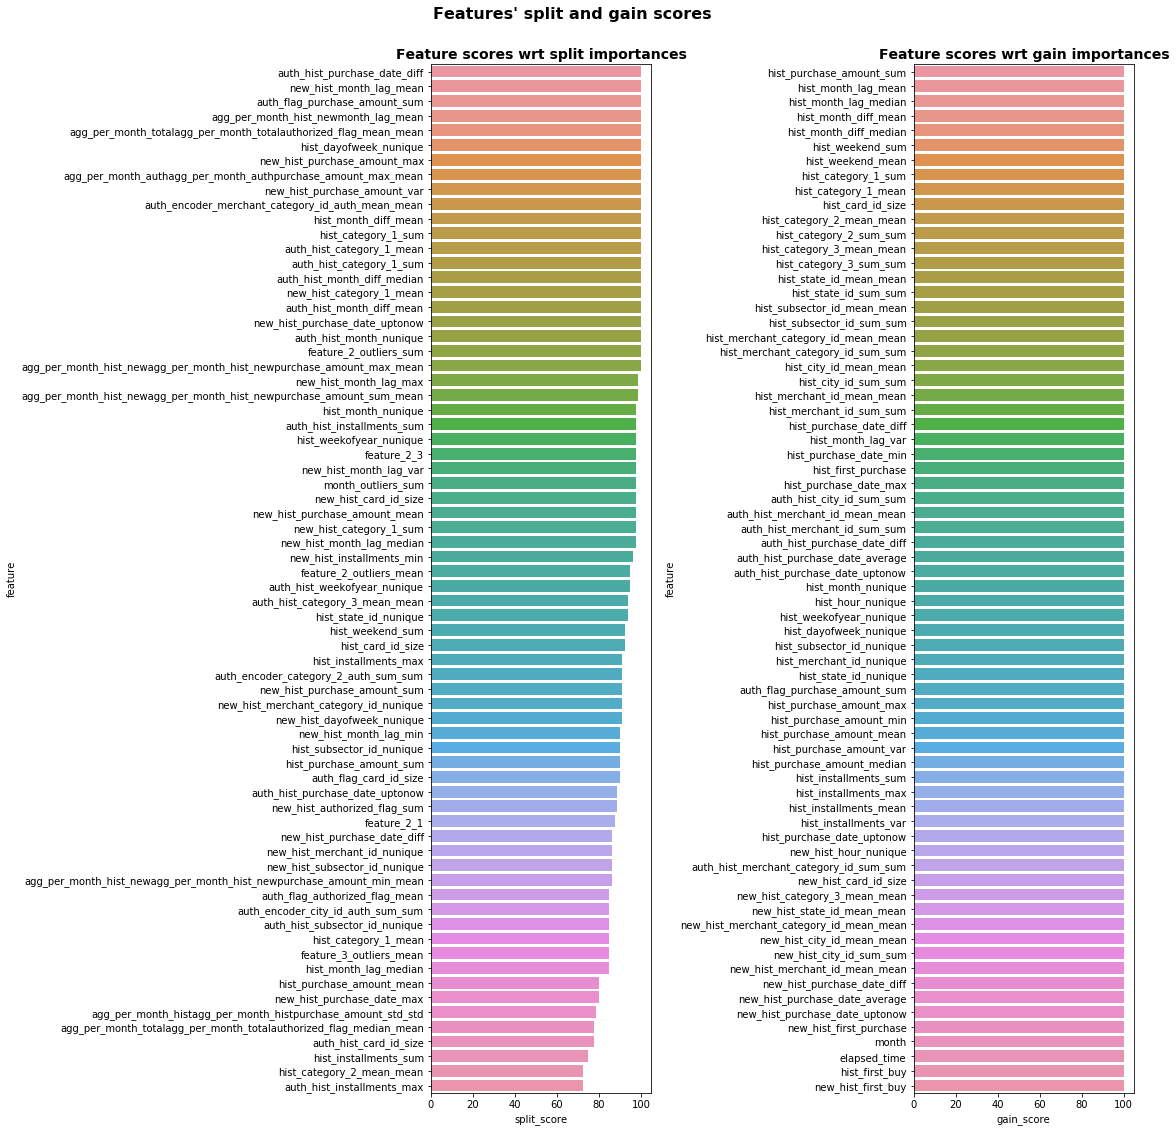

In [29]:
correlation_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].values
    gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].values
    split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    correlation_scores.append((_f, split_score, gain_score))

corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=corr_scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=corr_scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.suptitle("Features' split and gain scores", fontweight='bold', fontsize=16)
fig.subplots_adjust(top=0.93)

Score feature removal for different thresholds¶


In [30]:
for threshold in [0, 10, 20, 30 , 40, 50 ,60 , 70, 80 , 90, 95, 99]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    #split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    #gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    print(len(split_feats))                                                           

253
150
133
122
104
91
83
72
64
49
36
21


250
131
120
110
103
91
77
70
63
49
42
21

In [24]:
def score_feature_selection(df=None, train_features=None, cat_feats=None, target=None):
    # Fit LightGBM 
    
    dtrain = lgb.Dataset(df.loc[:,train_features], target, free_raw_data=False, silent=True)
    lgb_params = {'num_leaves': 31,
         'min_data_in_leaf': 32, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 42,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950,
         "device":"gpu"}
    
    # Fit the model
    hist = lgb.cv(
        params=lgb_params, 
        train_set=dtrain, 
        num_boost_round=2000,
        nfold=5,
        stratified=False,
        shuffle=True,
        early_stopping_rounds=50,
        verbose_eval=0,
        seed=17
    )
    # Return the last
    
    return hist['rmse-mean'][-1], hist['rmse-stdv'][-1]

# features = [f for f in data.columns if f not in ['SK_ID_CURR', 'TARGET']]
# score_feature_selection(df=data[features], train_features=features, target=data['TARGET'])

for threshold in [0, 10, 20, 30 , 40, 50 ,60 , 70, 80 , 90, 95, 99]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    #split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    #gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
                                                                                             
    print('Results for threshold %3d' % threshold)
    split_results = score_feature_selection(df=df_train, train_features=split_feats, cat_feats=None, target=df_train['target'])
    print('\t SPLIT : %.6f +/- %.6f' % (split_results[0], split_results[1]))
    gain_results = score_feature_selection(df=df_train, train_features=gain_feats, cat_feats=None, target=df_train['target'])
    print('\t GAIN  : %.6f +/- %.6f' % (gain_results[0], gain_results[1]))

    
    

Results for threshold   0
	 SPLIT : 3.647590 +/- 0.036224
	 GAIN  : 3.647976 +/- 0.036363
Results for threshold  10
	 SPLIT : 3.644733 +/- 0.037247
	 GAIN  : 3.648445 +/- 0.037327
Results for threshold  20
	 SPLIT : 3.643215 +/- 0.036726
	 GAIN  : 3.648799 +/- 0.036129
Results for threshold  30
	 SPLIT : 3.644804 +/- 0.037022
	 GAIN  : 3.648572 +/- 0.035442
Results for threshold  40
	 SPLIT : 3.642583 +/- 0.036469
	 GAIN  : 3.649581 +/- 0.035796
Results for threshold  50
	 SPLIT : 3.642769 +/- 0.036404
	 GAIN  : 3.648459 +/- 0.037615
Results for threshold  60
	 SPLIT : 3.643193 +/- 0.037339
	 GAIN  : 3.649065 +/- 0.036335
Results for threshold  70
	 SPLIT : 3.645077 +/- 0.036316
	 GAIN  : 3.647978 +/- 0.037054
Results for threshold  80
	 SPLIT : 3.645945 +/- 0.036604
	 GAIN  : 3.649186 +/- 0.037054
Results for threshold  90
	 SPLIT : 3.647475 +/- 0.037438
	 GAIN  : 3.648927 +/- 0.036650
Results for threshold  95
	 SPLIT : 3.649836 +/- 0.037840
	 GAIN  : 3.648477 +/- 0.035420
Results fo

In [31]:
def score_feature_selection(df=None, train_features=None, cat_feats=None, target=None):
    
    param = {'num_leaves': 31,
         'min_data_in_leaf': 32, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 42,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950,
         "device":"gpu"}
    
    folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=4950)
    oof = np.zeros(len(df))
    predictions = np.zeros(len(df_test))
    feature_importance_df = pd.DataFrame()
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(df,df['outliers'].values)):
#    print("fold {}".format(fold_))
#     trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
#     val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

        trn_data = lgb.Dataset(df.iloc[trn_idx][train_features], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
        val_data = lgb.Dataset(df.iloc[val_idx][train_features], label=target.iloc[val_idx])
    
        num_round = 10000
        clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data],verbose_eval=0, early_stopping_rounds = 100)
        oof[val_idx] = clf.predict(df.iloc[val_idx][train_features], num_iteration=clf.best_iteration)
    
#     fold_importance_df = pd.DataFrame()
#     fold_importance_df["Feature"] = train_features
#     fold_importance_df["importance"] = clf.feature_importance()
#     fold_importance_df["fold"] = fold_ + 1
#     feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
        predictions += clf.predict(df_test[train_features], num_iteration=clf.best_iteration) / folds.n_splits

    return np.sqrt(mean_squared_error(oof, target)),np.sqrt(mean_squared_error(predictions, y_test['target']))
split_results_list=[]
test_results=[]
for threshold in [ 0,10,20,30,40,50,60, 70,80, 90, 95]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    #split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    #gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
                                                                                             
    print('Results for threshold %3d' % threshold)
    split_results = score_feature_selection(df=df_train, train_features=split_feats, cat_feats=None, target=df_train['target'])
    print('\t SPLIT CV: '+str(split_results[0]))
    print('\t SPLIT TEST: '+str(split_results[1]))
    split_results_list.append(split_results[0])
    test_results.append(split_results[1])
#     gain_results = score_feature_selection(df=df_train, train_features=gain_feats, cat_feats=None, target=df_train['target'])
#     print('\t GAIN  : '+ str(gain_results))
#     gain_results_list.append(gain_results)

Results for threshold   0
	 SPLIT CV: 3.656481956847223
	 SPLIT TEST: 3.5785172040271496
Results for threshold  10
	 SPLIT CV: 3.653976934129618
	 SPLIT TEST: 3.5767802360845216
Results for threshold  20
	 SPLIT CV: 3.6523339139622997
	 SPLIT TEST: 3.577725248402262
Results for threshold  30
	 SPLIT CV: 3.650478673829386
	 SPLIT TEST: 3.5795809107068246
Results for threshold  40
	 SPLIT CV: 3.65134500635212
	 SPLIT TEST: 3.5819126392145604
Results for threshold  50
	 SPLIT CV: 3.651159284665138
	 SPLIT TEST: 3.5835832205745204
Results for threshold  60
	 SPLIT CV: 3.651123013526081
	 SPLIT TEST: 3.5839877491142245
Results for threshold  70
	 SPLIT CV: 3.6515560170633967
	 SPLIT TEST: 3.584806720864358
Results for threshold  80
	 SPLIT CV: 3.6498521734032416
	 SPLIT TEST: 3.585500827917225
Results for threshold  90
	 SPLIT CV: 3.6548660669652366
	 SPLIT TEST: 3.5962309595276674
Results for threshold  95
	 SPLIT CV: 3.6548779479041933
	 SPLIT TEST: 3.599793314850457


In [32]:
test_results

[3.5785172040271496,
 3.5767802360845216,
 3.577725248402262,
 3.5795809107068246,
 3.5819126392145604,
 3.5835832205745204,
 3.5839877491142245,
 3.584806720864358,
 3.585500827917225,
 3.5962309595276674,
 3.599793314850457]

In [27]:
str(split_results)

'3.6546764412973927'

Results for threshold   0
	 SPLIT : 3.653525 +/- 0.037462
	 GAIN  : 3.653525 +/- 0.037462
Results for threshold  10
	 SPLIT : 3.647332 +/- 0.038810
	 GAIN  : 3.653906 +/- 0.037102
Results for threshold  20
	 SPLIT : 3.648605 +/- 0.038934
	 GAIN  : 3.651490 +/- 0.037606
Results for threshold  30
	 SPLIT : 3.647871 +/- 0.037349
	 GAIN  : 3.651490 +/- 0.037606
Results for threshold  40
	 SPLIT : 3.647575 +/- 0.036816
	 GAIN  : 3.652654 +/- 0.037044
Results for threshold  50
	 SPLIT : 3.647932 +/- 0.037084
	 GAIN  : 3.652254 +/- 0.037573
Results for threshold  60
	 SPLIT : 3.647611 +/- 0.036503
	 GAIN  : 3.651592 +/- 0.037231
Results for threshold  70
	 SPLIT : 3.647497 +/- 0.037576
	 GAIN  : 3.651549 +/- 0.037122
Results for threshold  80
	 SPLIT : 3.649732 +/- 0.037814
	 GAIN  : 3.652329 +/- 0.037058
Results for threshold  90
	 SPLIT : 3.651710 +/- 0.037993
	 GAIN  : 3.651960 +/- 0.037423
Results for threshold  95
	 SPLIT : 3.654297 +/- 0.038320
	 GAIN  : 3.651504 +/- 0.037540
Results for threshold  99
	 SPLIT : 3.663244 +/- 0.040049
	 GAIN  : 3.651141 +/- 0.037911

In [33]:
corr_scores_df.to_csv('correlation_feature_scores_2extra_test10.csv')

In [34]:
split_results

(3.6548779479041933, 3.599793314850457)

In [35]:
for i in [10,20,30,40,50,60,70]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= i]
    df_split_feats=pd.DataFrame(split_feats)
    df_split_feats.to_csv('threshold_feature_elimination'+str(i)+'_2extra_test10.csv',index=False)


In [36]:
corr_scores_df.sort_values('split_score',ascending=False).feature.head(50)

112                         auth_hist_purchase_date_diff
196                              new_hist_month_lag_mean
1                          auth_flag_purchase_amount_sum
50                  agg_per_month_hist_newmonth_lag_mean
22     agg_per_month_totalagg_per_month_totalauthoriz...
119                               hist_dayofweek_nunique
181                         new_hist_purchase_amount_max
34     agg_per_month_authagg_per_month_authpurchase_a...
184                         new_hist_purchase_amount_var
14      auth_encoder_merchant_category_id_auth_mean_mean
145                                 hist_month_diff_mean
149                                  hist_category_1_sum
96                             auth_hist_category_1_mean
95                              auth_hist_category_1_sum
92                           auth_hist_month_diff_median
207                             new_hist_category_1_mean
91                             auth_hist_month_diff_mean
225                       new_h

### Now let's try with some features from merchant and historical transactions

In [37]:
data=pd.read_csv('merchants_map.csv')

In [38]:
df_train=df_train.merge(data,on='card_id')
df_test=df_test.merge(data,on='card_id')

In [39]:
# Select relevant features
exclude_features = []
exclude_features += ['card_id', 'first_active_month','target','outliers']
df_train_columns = [c for c in df_train.columns if c not in exclude_features ]
target = df_train['target']
#del df_train['target']

In [40]:

len(df_train_columns),len(exclude_features)

(259, 4)

### Below part is based on : 
https://www.kaggle.com/ogrellier/feature-selection-with-null-importances

In [41]:
def get_feature_importances(data, shuffle, seed=None):
    # Gather real features
    #train_features = [f for f in data if f not in ['TARGET', 'SK_ID_CURR']]
    # Go over fold and keep track of CV score (train and valid) and feature importances
    
    # Shuffle target if required
    y = data['target'].copy()
    if shuffle:
        # Here you could as well use a binomial distribution
        y = data['target'].copy().sample(frac=1.0)
    
    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    dtrain = lgb.Dataset(data.loc[:,df_train_columns], y, free_raw_data=False, silent=True)
    lgb_params = {'num_leaves': 31,
         'min_data_in_leaf': 32, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 42,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950,
         "device" : "gpu"}
    
    # Fit the model
    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200)

    #num_round = 1000
    #clf = lgb.train(lgb_params, dtrain, num_round, verbose_eval=100)
    #oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    #clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    #oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(df_train_columns)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    #imp_df['trn_score'] = roc_auc_score(y, clf.predict(data[train_features]))
    imp_df['trn_score']=np.sqrt(mean_squared_error(y, clf.predict(data.loc[:,df_train_columns])))
    
    return imp_df


In [42]:
# Seed the unexpected randomness of this world
np.random.seed(123)
# Get the actual importance, i.e. without shuffling
actual_imp_df = get_feature_importances(data=df_train, shuffle=False)

In [43]:
actual_imp_df.sort_values('importance_split',ascending=False).head()


,feature,importance_gain,importance_split,trn_score
225,new_hist_purchase_date_uptonow,1.101342e+06,272,3.570585
62,auth_hist_month_nunique,1.052110e+06,209,3.570585
181,new_hist_purchase_amount_max,7.003358e+05,178,3.570585
91,auth_hist_month_diff_mean,1.035003e+06,164,3.570585
196,new_hist_month_lag_mean,4.140789e+05,156,3.570585


In [44]:
actual_imp_df1=actual_imp_df.copy()

In [45]:
actual_imp_df.sort_values('importance_split',ascending=False).head()

,feature,importance_gain,importance_split,trn_score
225,new_hist_purchase_date_uptonow,1.101342e+06,272,3.570585
62,auth_hist_month_nunique,1.052110e+06,209,3.570585
181,new_hist_purchase_amount_max,7.003358e+05,178,3.570585
91,auth_hist_month_diff_mean,1.035003e+06,164,3.570585
196,new_hist_month_lag_mean,4.140789e+05,156,3.570585


In [46]:
actual_imp_df.sort_values('importance_split',ascending=False).head()

,feature,importance_gain,importance_split,trn_score
225,new_hist_purchase_date_uptonow,1.101342e+06,272,3.570585
62,auth_hist_month_nunique,1.052110e+06,209,3.570585
181,new_hist_purchase_amount_max,7.003358e+05,178,3.570585
91,auth_hist_month_diff_mean,1.035003e+06,164,3.570585
196,new_hist_month_lag_mean,4.140789e+05,156,3.570585


In [47]:
import time

In [48]:
null_imp_df = pd.DataFrame()
nb_runs = 80
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=df_train, shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

Done with   80 of   80 (Spent  13.9 min)

In [49]:
# Save importances just in case
null_imp_df.to_csv('null_importances_distribution_ref_8extra_test10.csv')
actual_imp_df.to_csv('actual_importances_ditribution_ref_8extra_test10.csv')

In [48]:
#actual_imp_df=feature_importance

In [49]:
# null_imp_df=pd.read_csv('null_importances_distribution_rf.csv')

Score features
There are several ways to score features :

Compute the number of samples in the actual importances that are away from the null importances recorded distribution.
Compute ratios like Actual / Null Max, Actual / Null Mean, Actual Mean / Null Max
In a first step I will use the log actual feature importance divided by the 75 percentile of null distribution.

In [50]:
import matplotlib.gridspec as gridspec
import seaborn as sns

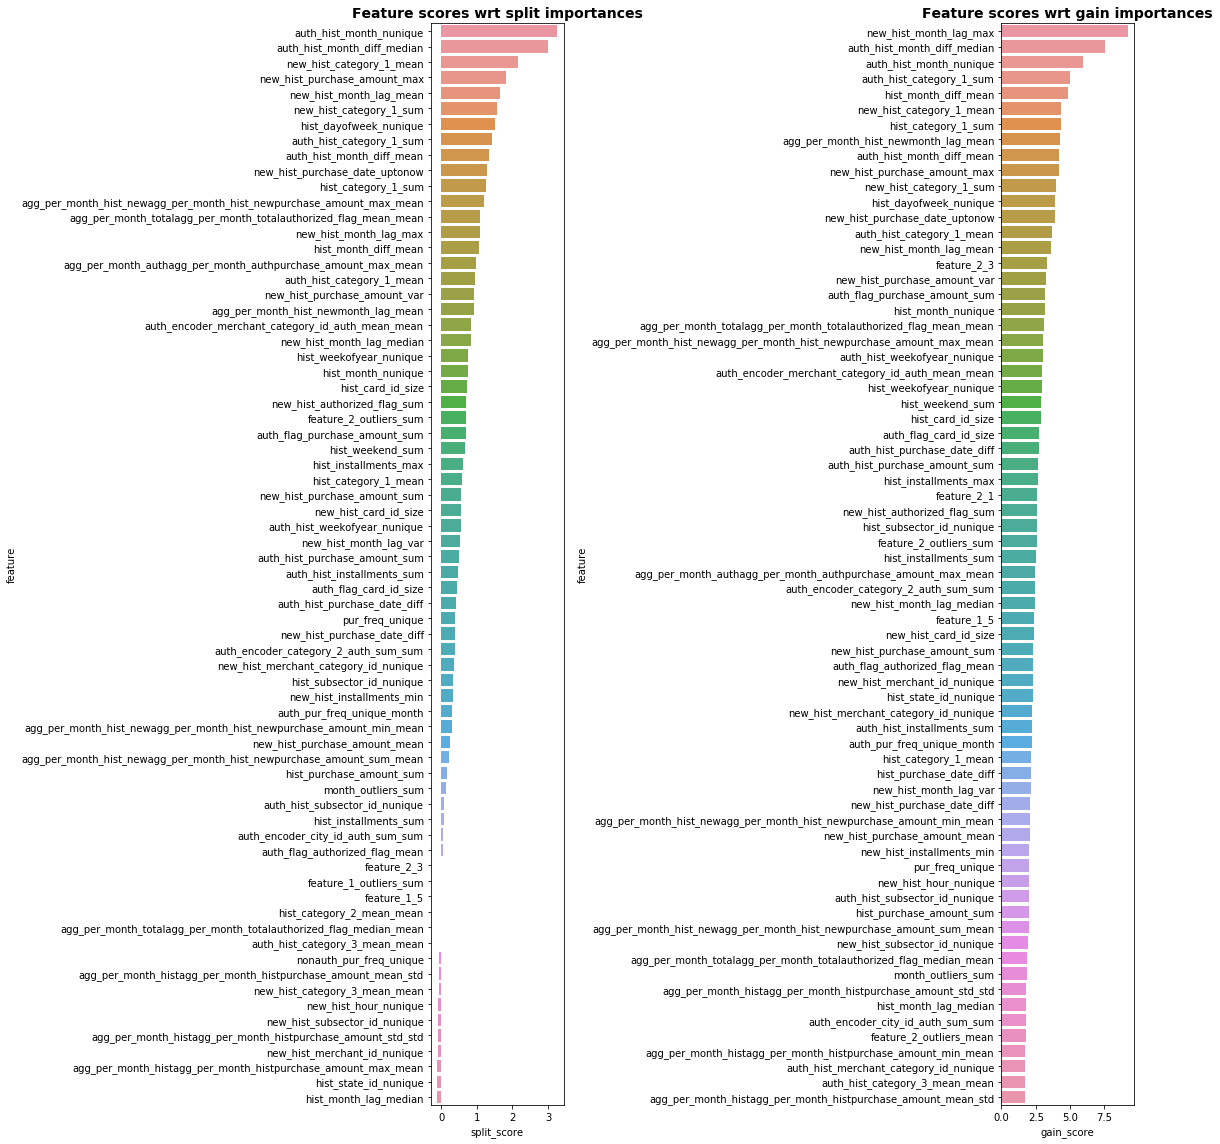

In [51]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()

Check the impact of removing uncorrelated features
Here I'll use a different metric to asses correlation to the target

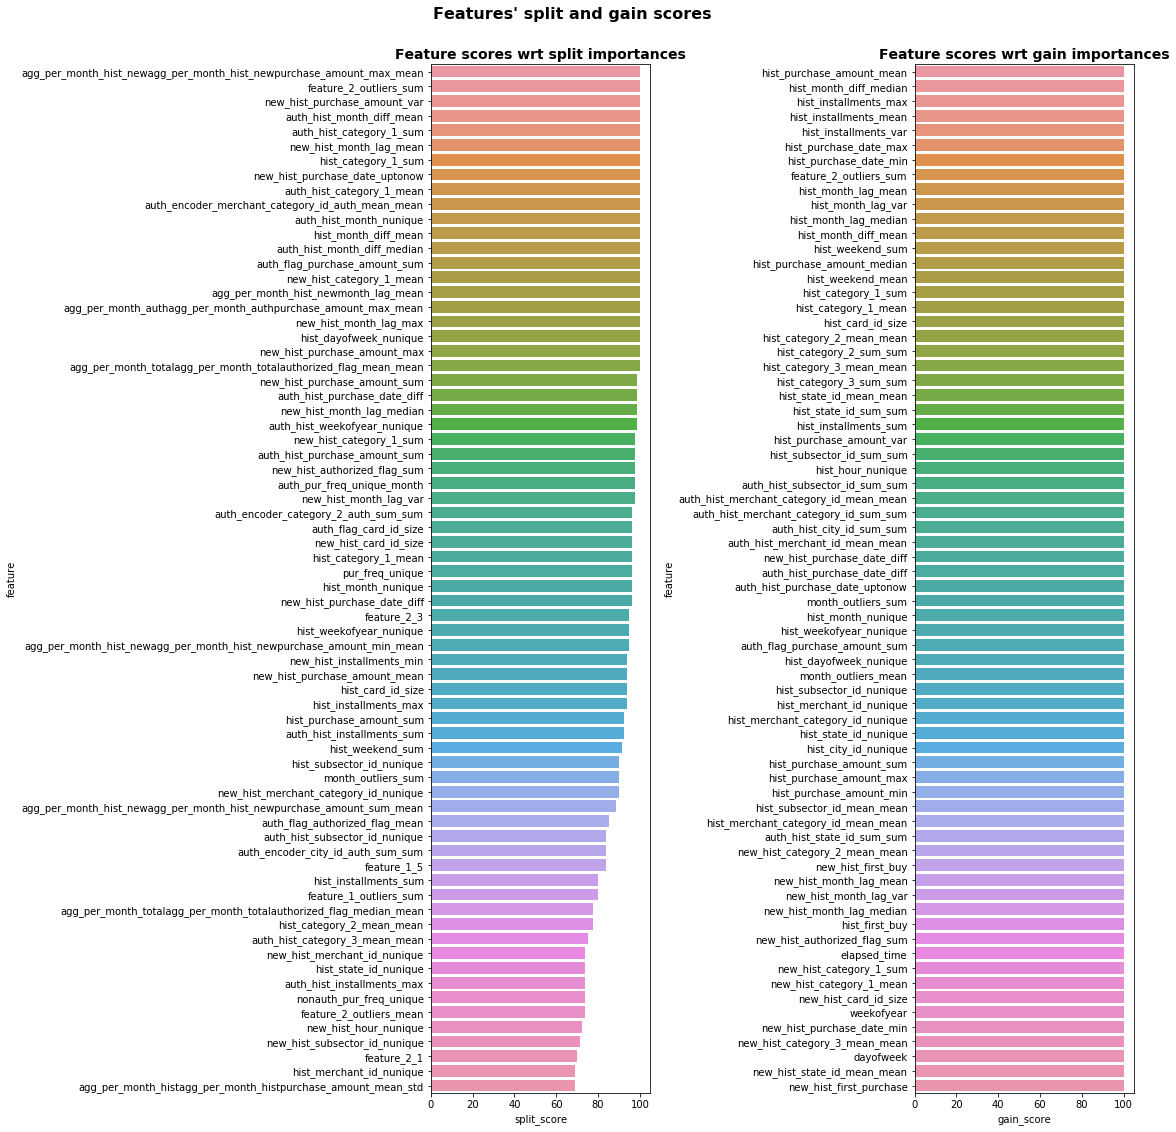

In [52]:
correlation_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].values
    gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].values
    split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    correlation_scores.append((_f, split_score, gain_score))

corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=corr_scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=corr_scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.suptitle("Features' split and gain scores", fontweight='bold', fontsize=16)
fig.subplots_adjust(top=0.93)

Score feature removal for different thresholds¶


In [53]:
for threshold in [0, 10, 20, 30 , 40, 50 ,60 , 70, 80 , 90, 95, 99]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    #split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    #gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    print(len(split_feats))                                                           

259
149
131
116
101
91
82
68
57
50
40
21


250
131
120
110
103
91
77
70
63
49
42
21

In [54]:
def score_feature_selection(df=None, train_features=None, cat_feats=None, target=None):
    
    param = {'num_leaves': 31,
         'min_data_in_leaf': 32, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 42,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950,
         "device":"gpu"}
    
    folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=4950)
    oof = np.zeros(len(df))
    predictions = np.zeros(len(df_test))
    feature_importance_df = pd.DataFrame()
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(df,df['outliers'].values)):
#    print("fold {}".format(fold_))
#     trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
#     val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

        trn_data = lgb.Dataset(df.iloc[trn_idx][train_features], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
        val_data = lgb.Dataset(df.iloc[val_idx][train_features], label=target.iloc[val_idx])
    
        num_round = 10000
        clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data],verbose_eval=0, early_stopping_rounds = 100)
        oof[val_idx] = clf.predict(df.iloc[val_idx][train_features], num_iteration=clf.best_iteration)
    
#     fold_importance_df = pd.DataFrame()
#     fold_importance_df["Feature"] = train_features
#     fold_importance_df["importance"] = clf.feature_importance()
#     fold_importance_df["fold"] = fold_ + 1
#     feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
        predictions += clf.predict(df_test[train_features], num_iteration=clf.best_iteration) / folds.n_splits

    return np.sqrt(mean_squared_error(oof, target)),np.sqrt(mean_squared_error(predictions, y_test['target']))
split_results_list=[]
test_results=[]
for threshold in [ 0,10,20,30,40,50,60, 70,80, 90, 95]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    #split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    #gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
                                                                                             
    print('Results for threshold %3d' % threshold)
    split_results = score_feature_selection(df=df_train, train_features=split_feats, cat_feats=None, target=df_train['target'])
    print('\t SPLIT CV: '+str(split_results[0]))
    print('\t SPLIT TEST: '+str(split_results[1]))
    split_results_list.append(split_results[0])
    test_results.append(split_results[1])
#     gain_results = score_feature_selection(df=df_train, train_features=gain_feats, cat_feats=None, target=df_train['target'])
#     print('\t GAIN  : '+ str(gain_results))
#     gain_results_list.append(gain_results)

Results for threshold   0
	 SPLIT CV: 3.654887614156242
	 SPLIT TEST: 3.5770019951002845
Results for threshold  10
	 SPLIT CV: 3.6516601440270517
	 SPLIT TEST: 3.576188088412434
Results for threshold  20
	 SPLIT CV: 3.6502558311479127
	 SPLIT TEST: 3.578049436849663
Results for threshold  30
	 SPLIT CV: 3.6506995480707674
	 SPLIT TEST: 3.578413378114601
Results for threshold  40
	 SPLIT CV: 3.65074149339562
	 SPLIT TEST: 3.577619244239765
Results for threshold  50
	 SPLIT CV: 3.6483544533354935
	 SPLIT TEST: 3.5784279986342367
Results for threshold  60
	 SPLIT CV: 3.6506915812953165
	 SPLIT TEST: 3.583244753567745
Results for threshold  70
	 SPLIT CV: 3.649491286355323
	 SPLIT TEST: 3.585254919812972
Results for threshold  80
	 SPLIT CV: 3.6522516709214967
	 SPLIT TEST: 3.5853705829331712
Results for threshold  90
	 SPLIT CV: 3.6519219219601986
	 SPLIT TEST: 3.59016503173777
Results for threshold  95
	 SPLIT CV: 3.6534986922652797
	 SPLIT TEST: 3.590450438223844


In [55]:
split_results_list

[3.654887614156242,
 3.6516601440270517,
 3.6502558311479127,
 3.6506995480707674,
 3.65074149339562,
 3.6483544533354935,
 3.6506915812953165,
 3.649491286355323,
 3.6522516709214967,
 3.6519219219601986,
 3.6534986922652797]

In [56]:
str(split_results)

'(3.6534986922652797, 3.590450438223844)'

Results for threshold   0
	 SPLIT : 3.653525 +/- 0.037462
	 GAIN  : 3.653525 +/- 0.037462
Results for threshold  10
	 SPLIT : 3.647332 +/- 0.038810
	 GAIN  : 3.653906 +/- 0.037102
Results for threshold  20
	 SPLIT : 3.648605 +/- 0.038934
	 GAIN  : 3.651490 +/- 0.037606
Results for threshold  30
	 SPLIT : 3.647871 +/- 0.037349
	 GAIN  : 3.651490 +/- 0.037606
Results for threshold  40
	 SPLIT : 3.647575 +/- 0.036816
	 GAIN  : 3.652654 +/- 0.037044
Results for threshold  50
	 SPLIT : 3.647932 +/- 0.037084
	 GAIN  : 3.652254 +/- 0.037573
Results for threshold  60
	 SPLIT : 3.647611 +/- 0.036503
	 GAIN  : 3.651592 +/- 0.037231
Results for threshold  70
	 SPLIT : 3.647497 +/- 0.037576
	 GAIN  : 3.651549 +/- 0.037122
Results for threshold  80
	 SPLIT : 3.649732 +/- 0.037814
	 GAIN  : 3.652329 +/- 0.037058
Results for threshold  90
	 SPLIT : 3.651710 +/- 0.037993
	 GAIN  : 3.651960 +/- 0.037423
Results for threshold  95
	 SPLIT : 3.654297 +/- 0.038320
	 GAIN  : 3.651504 +/- 0.037540
Results for threshold  99
	 SPLIT : 3.663244 +/- 0.040049
	 GAIN  : 3.651141 +/- 0.037911

In [57]:
corr_scores_df.to_csv('correlation_feature_scores_8extra_test10.csv')

In [59]:
split_results

3.6559742692001125

In [58]:
for i in [10,20,30,40,50,60,70]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= i]
    df_split_feats=pd.DataFrame(split_feats)
    df_split_feats.to_csv('threshold_feature_elimination'+str(i)+'_8extra_test10.csv',index=False)


### Now, let's train without outliers

In [168]:
from sklearn import metrics

In [169]:
def get_feature_importances(data, shuffle, seed=None):
    # Gather real features
    #train_features = [f for f in data if f not in ['TARGET', 'SK_ID_CURR']]
    # Go over fold and keep track of CV score (train and valid) and feature importances
    
    # Shuffle target if required
    y = data['outliers'].copy()
    if shuffle:
        # Here you could as well use a binomial distribution
        y = data['outliers'].copy().sample(frac=1.0)
    
    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    dtrain = lgb.Dataset(data.loc[:,df_train_columns], y, free_raw_data=False, silent=True)
    lgb_params = {'num_leaves': 31,
         'min_data_in_leaf': 20, 
         'objective':'binary',
         'max_depth': -1,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 42,
         "metric": 'auc',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950,
        "scale_pos_weight": 15,
         "device" : "gpu"}
    

    
    # Fit the model
    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=400)

    #num_round = 1000
    #clf = lgb.train(lgb_params, dtrain, num_round, verbose_eval=100)
    #oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    #clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    #oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(df_train_columns)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    #imp_df['trn_score'] = roc_auc_score(y, clf.predict(data[train_features]))
    
    imp_df['trn_score']=metrics.log_loss(y, clf.predict(data.loc[:,df_train_columns]))
    
    return imp_df


In [170]:
# Seed the unexpected randomness of this world
np.random.seed(123)
# Get the actual importance, i.e. without shuffling
actual_imp_df = get_feature_importances(data=df_train, shuffle=False)

In [171]:
actual_imp_df.sort_values('importance_split',ascending=False).head()


,feature,importance_gain,importance_split,trn_score
62,auth_hist_month_nunique,504755.951252,314,0.092832
91,auth_hist_month_diff_mean,684865.734783,216,0.092832
84,auth_hist_purchase_date_max,252760.981880,203,0.092832
232,hist_first_buy,33613.475315,179,0.092832
14,auth_encoder_merchant_category_id_auth_mean_mean,56020.590111,177,0.092832


In [172]:
actual_imp_df1=actual_imp_df.copy()

In [173]:
actual_imp_df.sort_values('importance_split',ascending=False).head()

,feature,importance_gain,importance_split,trn_score
62,auth_hist_month_nunique,504755.951252,314,0.092832
91,auth_hist_month_diff_mean,684865.734783,216,0.092832
84,auth_hist_purchase_date_max,252760.981880,203,0.092832
232,hist_first_buy,33613.475315,179,0.092832
14,auth_encoder_merchant_category_id_auth_mean_mean,56020.590111,177,0.092832


In [174]:
actual_imp_df.sort_values('importance_split',ascending=False).head()

,feature,importance_gain,importance_split,trn_score
62,auth_hist_month_nunique,504755.951252,314,0.092832
91,auth_hist_month_diff_mean,684865.734783,216,0.092832
84,auth_hist_purchase_date_max,252760.981880,203,0.092832
232,hist_first_buy,33613.475315,179,0.092832
14,auth_encoder_merchant_category_id_auth_mean_mean,56020.590111,177,0.092832


In [175]:
import time

In [176]:
null_imp_df = pd.DataFrame()
nb_runs = 80
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=df_train, shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

Done with   80 of   80 (Spent  25.7 min)

In [177]:
# Save importances just in case
null_imp_df.to_csv('null_importances_distribution_ref_8extra_test10_outliers_pred.csv')
actual_imp_df.to_csv('actual_importances_ditribution_ref_8extra_test10_outliers_pred.csv')

In [178]:
#actual_imp_df=feature_importance

In [179]:
# null_imp_df=pd.read_csv('null_importances_distribution_rf.csv')

Score features
There are several ways to score features :

Compute the number of samples in the actual importances that are away from the null importances recorded distribution.
Compute ratios like Actual / Null Max, Actual / Null Mean, Actual Mean / Null Max
In a first step I will use the log actual feature importance divided by the 75 percentile of null distribution.

In [180]:
import matplotlib.gridspec as gridspec
import seaborn as sns

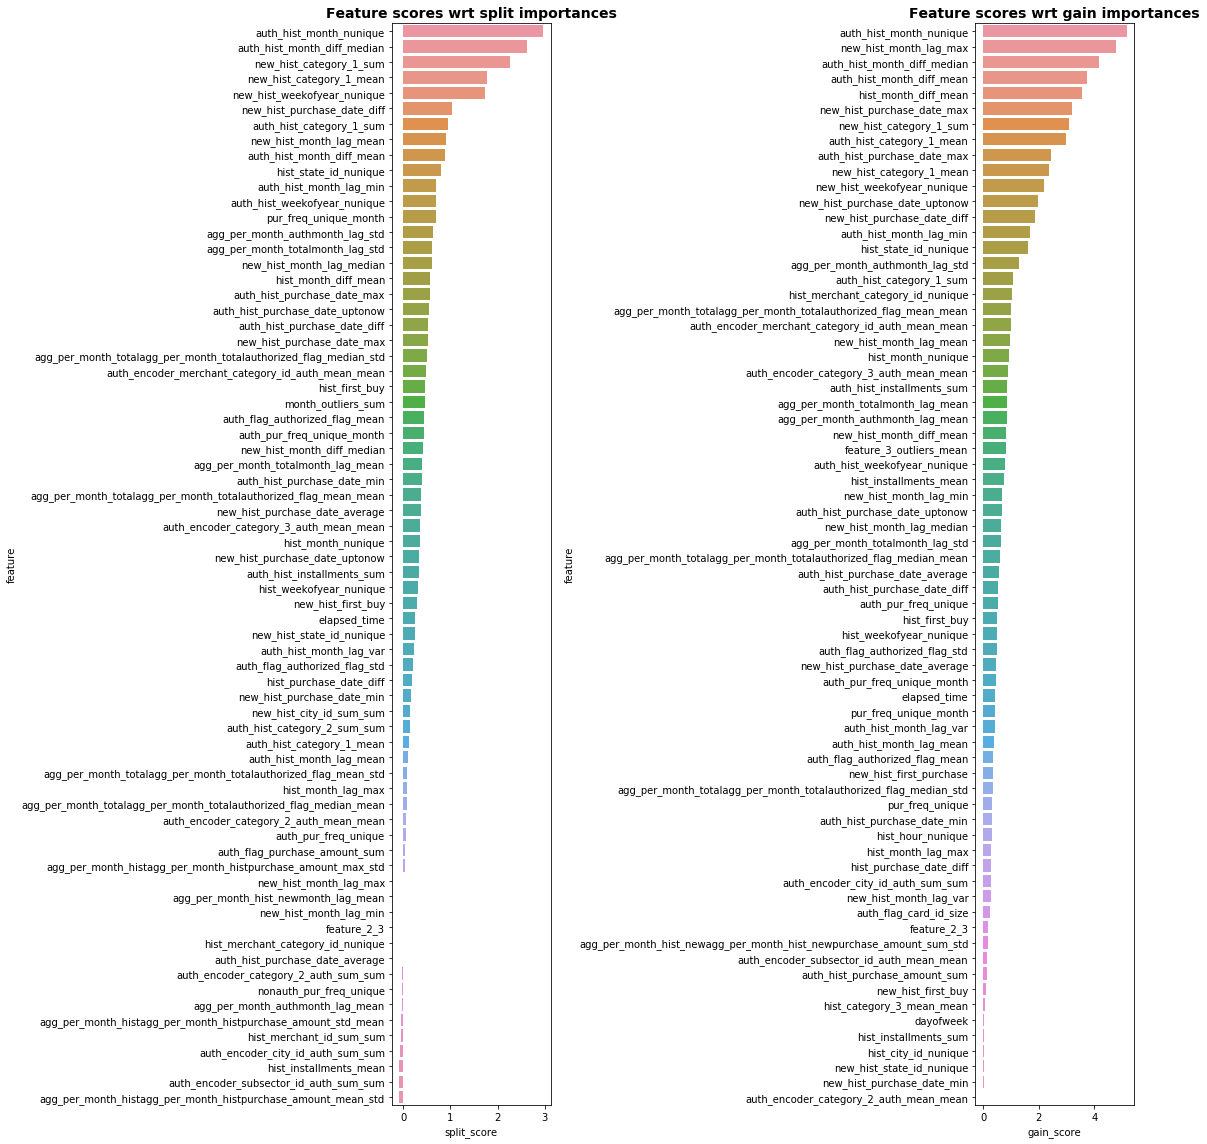

In [181]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()

Check the impact of removing uncorrelated features
Here I'll use a different metric to asses correlation to the target

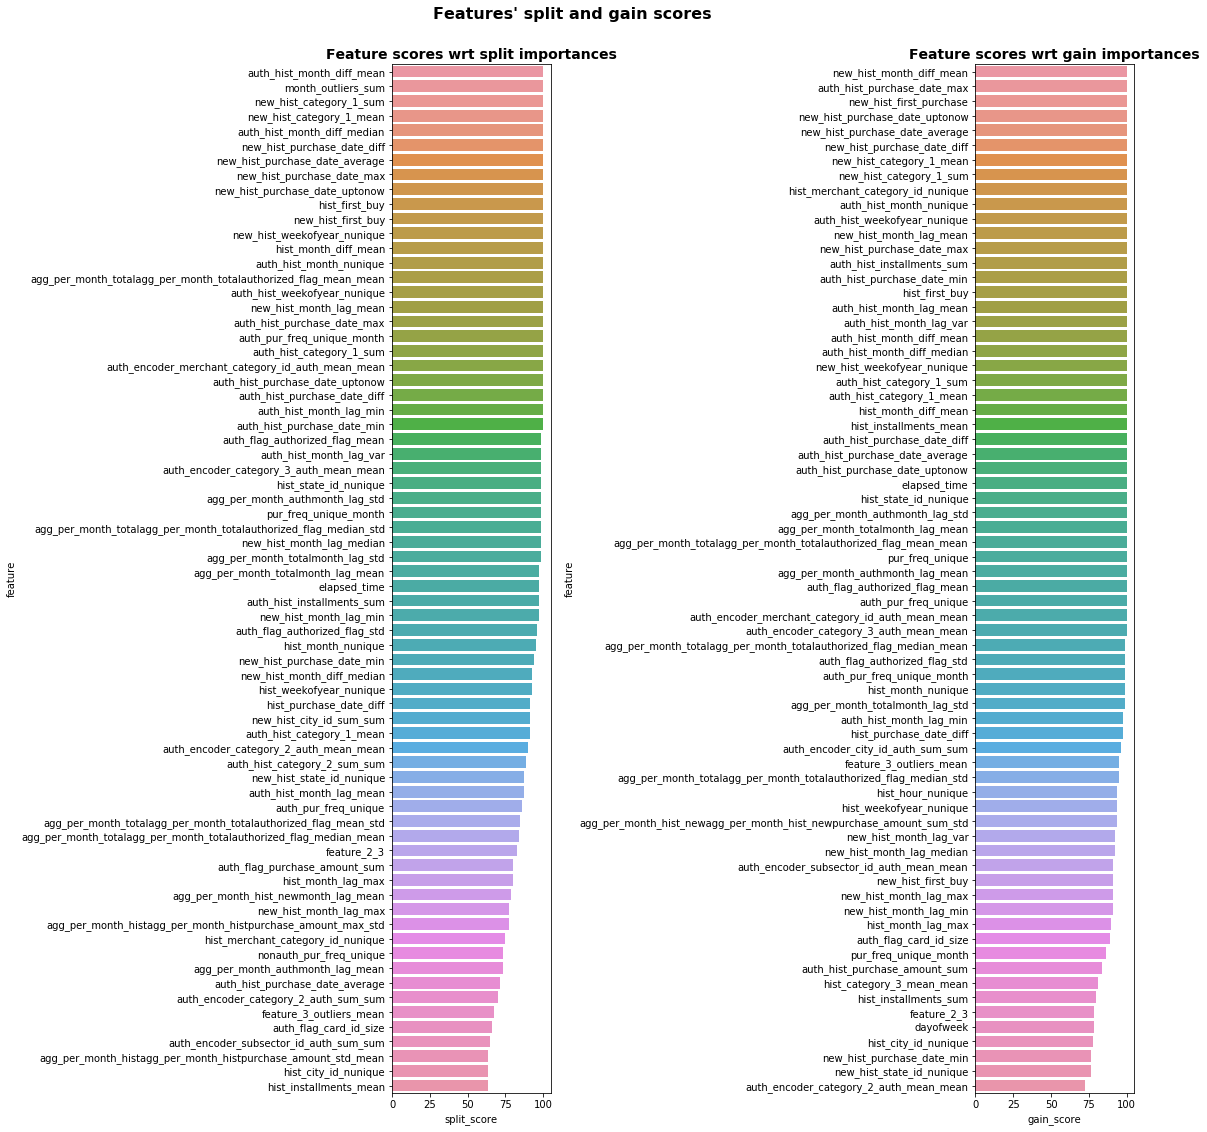

In [182]:
correlation_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].values
    gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].values
    split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    correlation_scores.append((_f, split_score, gain_score))

corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=corr_scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=corr_scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.suptitle("Features' split and gain scores", fontweight='bold', fontsize=16)
fig.subplots_adjust(top=0.93)

Score feature removal for different thresholds¶


In [183]:
for threshold in [0, 10, 20, 30 , 40, 50 ,60 , 70, 80 , 90, 95, 99]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    #split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    #gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    print(len(split_feats))                                                           

259
170
138
115
98
85
75
64
56
47
40
25


250
131
120
110
103
91
77
70
63
49
42
21

In [184]:
y_test['outliers'].sum()

212

In [185]:
def score_feature_selection(df=None, train_features=None, cat_feats=None, target=None):
    
    param = {'num_leaves': 31,
         'min_data_in_leaf': 20, 
         'objective':'binary',
         'max_depth': -1,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 42,
         "metric": 'auc',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950,
        "scale_pos_weight": 15,
         "device" : "gpu"}
    
    folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=4950)
    oof = np.zeros(len(df))
    predictions = np.zeros(len(df_test))
    feature_importance_df = pd.DataFrame()
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(df,df['outliers'].values)):
#    print("fold {}".format(fold_))
#     trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
#     val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

        trn_data = lgb.Dataset(df.iloc[trn_idx][train_features], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
        val_data = lgb.Dataset(df.iloc[val_idx][train_features], label=target.iloc[val_idx])
    
        num_round = 10000
        clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data],verbose_eval=0, early_stopping_rounds = 100)
        oof[val_idx] = clf.predict(df.iloc[val_idx][train_features], num_iteration=clf.best_iteration)
    
#     fold_importance_df = pd.DataFrame()
#     fold_importance_df["Feature"] = train_features
#     fold_importance_df["importance"] = clf.feature_importance()
#     fold_importance_df["fold"] = fold_ + 1
#     feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
        predictions += clf.predict(df_test[train_features], num_iteration=clf.best_iteration) / folds.n_splits

    return metrics.log_loss(target, oof),metrics.log_loss(y_test['outliers'],predictions)
split_results_list=[]
test_results=[]
for threshold in [ 0,10,20,30,40,50,60, 70,80, 90, 95]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    #split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    #gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
                                                                                             
    print('Results for threshold %3d' % threshold)
    split_results = score_feature_selection(df=df_train, train_features=split_feats, cat_feats=None, target=df_train['outliers'])
    print('\t SPLIT CV: '+str(split_results[0]))
    print('\t SPLIT TEST: '+str(split_results[1]))
    split_results_list.append(split_results[0])
    test_results.append(split_results[1])
#     gain_results = score_feature_selection(df=df_train, train_features=gain_feats, cat_feats=None, target=df_train['target'])
#     print('\t GAIN  : '+ str(gain_results))
#     gain_results_list.append(gain_results)

Results for threshold   0
	 SPLIT CV: 0.09750727912192701
	 SPLIT TEST: 0.0967199077073159
Results for threshold  10
	 SPLIT CV: 0.09884202376233187
	 SPLIT TEST: 0.09801151129906009
Results for threshold  20
	 SPLIT CV: 0.09653347329821943
	 SPLIT TEST: 0.09532164220671634
Results for threshold  30
	 SPLIT CV: 0.09507455676437193
	 SPLIT TEST: 0.09349111024624165
Results for threshold  40
	 SPLIT CV: 0.09455652239505555
	 SPLIT TEST: 0.09232669877906864
Results for threshold  50
	 SPLIT CV: 0.09639180351502682
	 SPLIT TEST: 0.0944471826203509
Results for threshold  60
	 SPLIT CV: 0.09646309560189598
	 SPLIT TEST: 0.09504919863945291
Results for threshold  70
	 SPLIT CV: 0.1006853138251917
	 SPLIT TEST: 0.09978493549599948
Results for threshold  80
	 SPLIT CV: 0.09537927304127121
	 SPLIT TEST: 0.09266581091938512
Results for threshold  90
	 SPLIT CV: 0.09658272151809204
	 SPLIT TEST: 0.09315883350565449
Results for threshold  95
	 SPLIT CV: 0.09878921144693457
	 SPLIT TEST: 0.097004718

In [186]:
split_results_list

[0.09750727912192701,
 0.09884202376233187,
 0.09653347329821943,
 0.09507455676437193,
 0.09455652239505555,
 0.09639180351502682,
 0.09646309560189598,
 0.1006853138251917,
 0.09537927304127121,
 0.09658272151809204,
 0.09878921144693457]

In [187]:
test_results

[0.0967199077073159,
 0.09801151129906009,
 0.09532164220671634,
 0.09349111024624165,
 0.09232669877906864,
 0.0944471826203509,
 0.09504919863945291,
 0.09978493549599948,
 0.09266581091938512,
 0.09315883350565449,
 0.09700471828512955]

In [188]:
str(split_results)

'(0.09878921144693457, 0.09700471828512955)'

Results for threshold   0
	 SPLIT : 3.653525 +/- 0.037462
	 GAIN  : 3.653525 +/- 0.037462
Results for threshold  10
	 SPLIT : 3.647332 +/- 0.038810
	 GAIN  : 3.653906 +/- 0.037102
Results for threshold  20
	 SPLIT : 3.648605 +/- 0.038934
	 GAIN  : 3.651490 +/- 0.037606
Results for threshold  30
	 SPLIT : 3.647871 +/- 0.037349
	 GAIN  : 3.651490 +/- 0.037606
Results for threshold  40
	 SPLIT : 3.647575 +/- 0.036816
	 GAIN  : 3.652654 +/- 0.037044
Results for threshold  50
	 SPLIT : 3.647932 +/- 0.037084
	 GAIN  : 3.652254 +/- 0.037573
Results for threshold  60
	 SPLIT : 3.647611 +/- 0.036503
	 GAIN  : 3.651592 +/- 0.037231
Results for threshold  70
	 SPLIT : 3.647497 +/- 0.037576
	 GAIN  : 3.651549 +/- 0.037122
Results for threshold  80
	 SPLIT : 3.649732 +/- 0.037814
	 GAIN  : 3.652329 +/- 0.037058
Results for threshold  90
	 SPLIT : 3.651710 +/- 0.037993
	 GAIN  : 3.651960 +/- 0.037423
Results for threshold  95
	 SPLIT : 3.654297 +/- 0.038320
	 GAIN  : 3.651504 +/- 0.037540
Results for threshold  99
	 SPLIT : 3.663244 +/- 0.040049
	 GAIN  : 3.651141 +/- 0.037911

In [189]:
corr_scores_df.to_csv('correlation_feature_scores_8extra_test10_outliers_pred.csv')

In [190]:
split_results

(0.09878921144693457, 0.09700471828512955)

In [191]:
for i in [10,20,30,40,50,60,70,80,90,95]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= i]
    df_split_feats=pd.DataFrame(split_feats)
    df_split_feats.to_csv('threshold_feature_elimination'+str(i)+'_8extra_test10_outliers_pred.csv',index=False)


### Now let's do feature elimination for model without outliers


In [114]:
from sklearn.metrics import log_loss

In [139]:
df_train_original=df_train.copy()
df_test_original=df_test.copy()
y_train_original=y_train.copy()
y_test_original=y_test.copy()

df_train=df_train[df_train['outliers']==0]
df_test=df_test[df_test['outliers']==0]
y_train=y_train[y_train['outliers']==0]
y_test=y_test[y_test['outliers']==0]


In [140]:
df_train.shape,df_train_original.shape

((179730, 263), (181725, 263))

In [115]:
from sklearn import metrics

In [142]:
def get_feature_importances(data, shuffle, seed=None):
    # Gather real features
    #train_features = [f for f in data if f not in ['TARGET', 'SK_ID_CURR']]
    # Go over fold and keep track of CV score (train and valid) and feature importances
    
    # Shuffle target if required
    y = data['target'].copy()
    if shuffle:
        # Here you could as well use a binomial distribution
        y = data['target'].copy().sample(frac=1.0)
    
    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    dtrain = lgb.Dataset(data.loc[:,df_train_columns], y, free_raw_data=False, silent=True)
    lgb_params = {'num_leaves': 31,
         'min_data_in_leaf': 32, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 42,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950,
         "device":"gpu"}
    

    
    # Fit the model
    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=400)

    #num_round = 1000
    #clf = lgb.train(lgb_params, dtrain, num_round, verbose_eval=100)
    #oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    #clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    #oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(df_train_columns)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    #imp_df['trn_score'] = roc_auc_score(y, clf.predict(data[train_features]))
    
    imp_df['trn_score']=np.sqrt(mean_squared_error(y, clf.predict(data.loc[:,df_train_columns])))
    
    return imp_df


In [143]:
# Seed the unexpected randomness of this world
np.random.seed(123)
# Get the actual importance, i.e. without shuffling
actual_imp_df = get_feature_importances(data=df_train, shuffle=False)

In [144]:
actual_imp_df.sort_values('importance_split',ascending=False).head()


,feature,importance_gain,importance_split,trn_score
181,new_hist_purchase_amount_max,921538.771374,971,1.544598
34,agg_per_month_authagg_per_month_authpurchase_a...,249055.482796,802,1.544598
253,pur_freq_unique,246466.171501,632,1.544598
58,agg_per_month_hist_newagg_per_month_hist_newpu...,193201.927143,459,1.544598
77,auth_hist_purchase_amount_median,51201.332336,375,1.544598


In [145]:
actual_imp_df1=actual_imp_df.copy()

In [146]:
actual_imp_df.sort_values('importance_split',ascending=False).head()

,feature,importance_gain,importance_split,trn_score
181,new_hist_purchase_amount_max,921538.771374,971,1.544598
34,agg_per_month_authagg_per_month_authpurchase_a...,249055.482796,802,1.544598
253,pur_freq_unique,246466.171501,632,1.544598
58,agg_per_month_hist_newagg_per_month_hist_newpu...,193201.927143,459,1.544598
77,auth_hist_purchase_amount_median,51201.332336,375,1.544598


In [147]:
actual_imp_df.sort_values('importance_split',ascending=False).head()

,feature,importance_gain,importance_split,trn_score
181,new_hist_purchase_amount_max,921538.771374,971,1.544598
34,agg_per_month_authagg_per_month_authpurchase_a...,249055.482796,802,1.544598
253,pur_freq_unique,246466.171501,632,1.544598
58,agg_per_month_hist_newagg_per_month_hist_newpu...,193201.927143,459,1.544598
77,auth_hist_purchase_amount_median,51201.332336,375,1.544598


In [148]:
import time

In [149]:
null_imp_df = pd.DataFrame()
nb_runs = 80
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=df_train, shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

Done with   80 of   80 (Spent  22.1 min)

In [150]:
# Save importances just in case
null_imp_df.to_csv('null_importances_distribution_ref_8extra_test10_without_outliers.csv')
actual_imp_df.to_csv('actual_importances_ditribution_ref_8extra_test10_without_outliers.csv')

In [108]:
#actual_imp_df=feature_importance

In [109]:
# null_imp_df=pd.read_csv('null_importances_distribution_rf.csv')

Score features
There are several ways to score features :

Compute the number of samples in the actual importances that are away from the null importances recorded distribution.
Compute ratios like Actual / Null Max, Actual / Null Mean, Actual Mean / Null Max
In a first step I will use the log actual feature importance divided by the 75 percentile of null distribution.

In [151]:
import matplotlib.gridspec as gridspec
import seaborn as sns

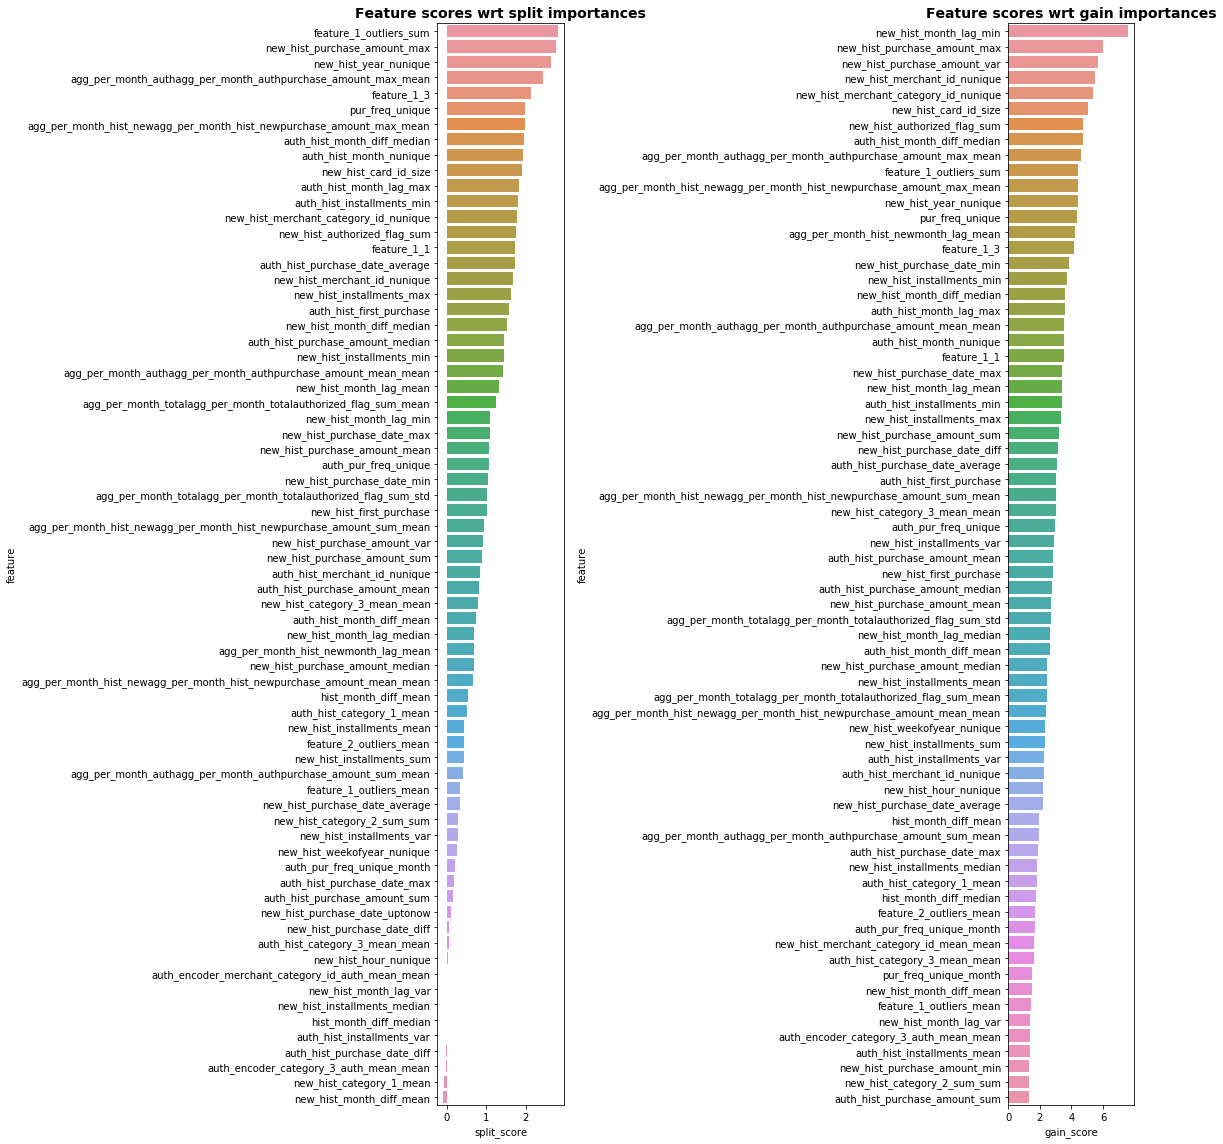

In [152]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()

Check the impact of removing uncorrelated features
Here I'll use a different metric to asses correlation to the target

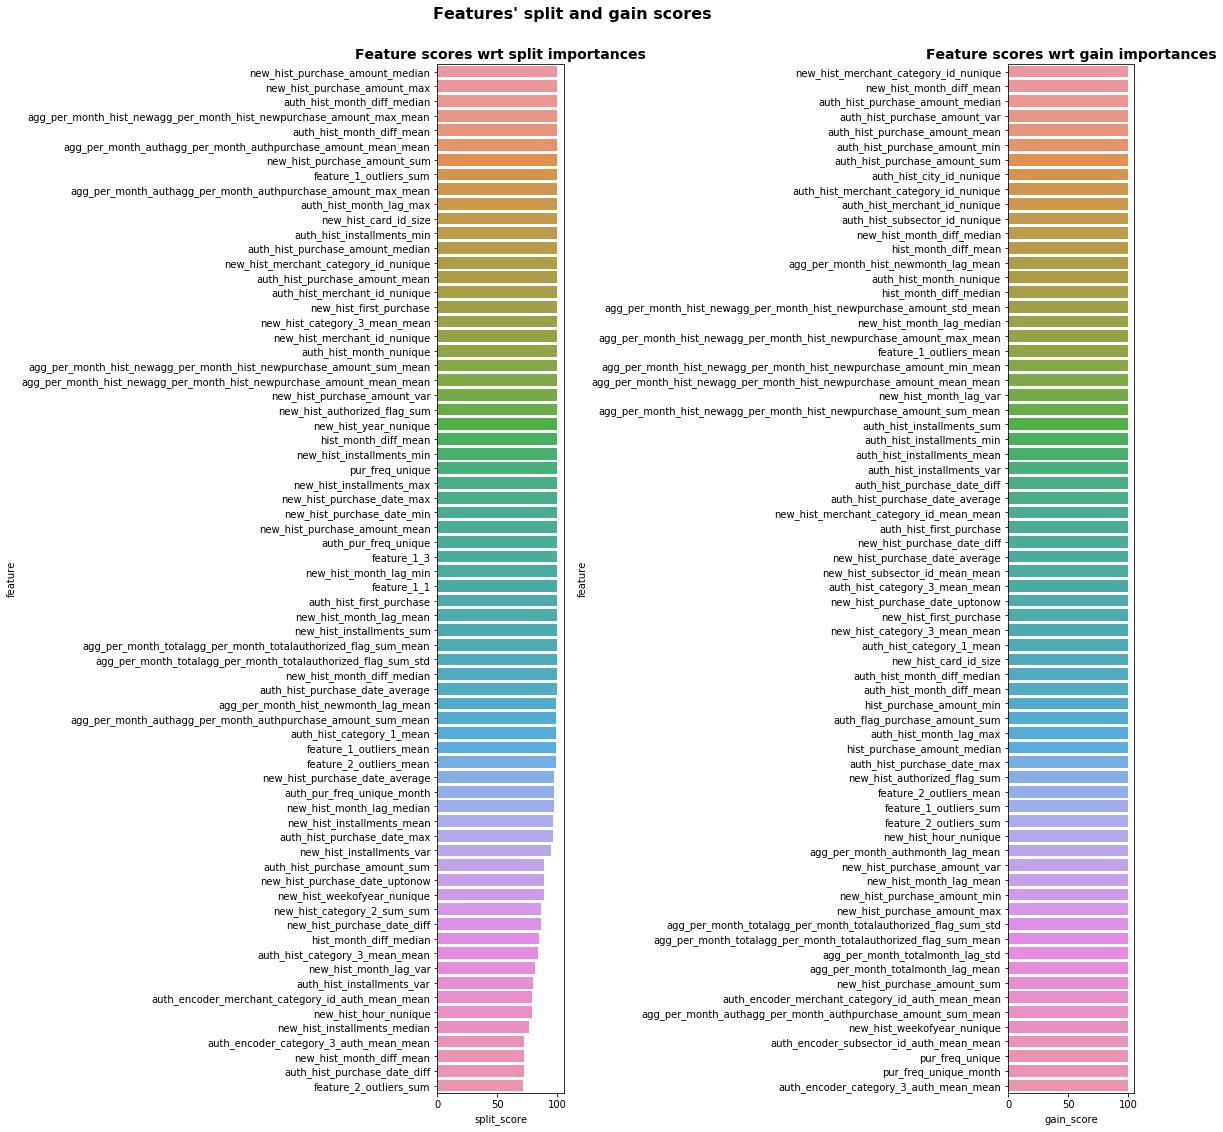

In [153]:
correlation_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].values
    gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].values
    split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    correlation_scores.append((_f, split_score, gain_score))

corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=corr_scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=corr_scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.suptitle("Features' split and gain scores", fontweight='bold', fontsize=16)
fig.subplots_adjust(top=0.93)

Score feature removal for different thresholds¶


In [154]:
for threshold in [0, 10, 20, 30 , 40, 50 ,60 , 70, 80 , 90, 95, 99]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    #split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    #gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    print(len(split_feats))                                                           

259
86
81
80
76
73
71
71
63
54
54
43


250
131
120
110
103
91
77
70
63
49
42
21

In [155]:
def score_feature_selection(df=None, train_features=None, cat_feats=None, target=None):
    
    param = {'num_leaves': 31,
         'min_data_in_leaf': 32, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 42,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950,
         "device":"gpu"}
    
    folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=4950)
    oof = np.zeros(len(df))
    predictions = np.zeros(len(df_test))
    feature_importance_df = pd.DataFrame()
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(df,df['outliers'].values)):
#    print("fold {}".format(fold_))
#     trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
#     val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

        trn_data = lgb.Dataset(df.iloc[trn_idx][train_features], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
        val_data = lgb.Dataset(df.iloc[val_idx][train_features], label=target.iloc[val_idx])
    
        num_round = 10000
        clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data],verbose_eval=0, early_stopping_rounds = 100)
        oof[val_idx] = clf.predict(df.iloc[val_idx][train_features], num_iteration=clf.best_iteration)
    
#     fold_importance_df = pd.DataFrame()
#     fold_importance_df["Feature"] = train_features
#     fold_importance_df["importance"] = clf.feature_importance()
#     fold_importance_df["fold"] = fold_ + 1
#     feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
        predictions += clf.predict(df_test[train_features], num_iteration=clf.best_iteration) / folds.n_splits

    return np.sqrt(mean_squared_error(target, oof)),np.sqrt(mean_squared_error(y_test['target'],predictions))
split_results_list=[]
test_results=[]
for threshold in [ 0,10,20,30,40,50,60, 70,80, 90, 95]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    #split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    #gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
                                                                                             
    print('Results for threshold %3d' % threshold)
    split_results = score_feature_selection(df=df_train, train_features=split_feats, cat_feats=None, target=df_train['target'])
    print('\t SPLIT CV: '+str(split_results[0]))
    print('\t SPLIT TEST: '+str(split_results[1]))
    split_results_list.append(split_results[0])
    test_results.append(split_results[1])
#     gain_results = score_feature_selection(df=df_train, train_features=gain_feats, cat_feats=None, target=df_train['target'])
#     print('\t GAIN  : '+ str(gain_results))
#     gain_results_list.append(gain_results)

Results for threshold   0
	 SPLIT CV: 1.5533060246918315
	 SPLIT TEST: 1.5476712822423822
Results for threshold  10
	 SPLIT CV: 1.5514138780359128
	 SPLIT TEST: 1.5458325838239855
Results for threshold  20
	 SPLIT CV: 1.5516397224714285
	 SPLIT TEST: 1.5460600083272549
Results for threshold  30
	 SPLIT CV: 1.5515993996489017
	 SPLIT TEST: 1.54624943637558
Results for threshold  40
	 SPLIT CV: 1.5518610591343849
	 SPLIT TEST: 1.5464836661753323
Results for threshold  50
	 SPLIT CV: 1.5518848306943962
	 SPLIT TEST: 1.546263293620046
Results for threshold  60
	 SPLIT CV: 1.5517744207907767
	 SPLIT TEST: 1.5459621119921578
Results for threshold  70
	 SPLIT CV: 1.5518553696441226
	 SPLIT TEST: 1.5460367360667338
Results for threshold  80
	 SPLIT CV: 1.5525726650716072
	 SPLIT TEST: 1.5466193077887624
Results for threshold  90
	 SPLIT CV: 1.553188903667996
	 SPLIT TEST: 1.5471244285324082
Results for threshold  95
	 SPLIT CV: 1.5531669180436722
	 SPLIT TEST: 1.547169395449606


In [161]:
split_results_list

[1.5533060246918315,
 1.5514138780359128,
 1.5516397224714285,
 1.5515993996489017,
 1.5518610591343849,
 1.5518848306943962,
 1.5517744207907767,
 1.5518553696441226,
 1.5525726650716072,
 1.553188903667996,
 1.5531669180436722]

In [162]:
test_results

[1.5476712822423822,
 1.5458325838239855,
 1.5460600083272549,
 1.54624943637558,
 1.5464836661753323,
 1.546263293620046,
 1.5459621119921578,
 1.5460367360667338,
 1.5466193077887624,
 1.5471244285324082,
 1.547169395449606]

In [163]:
str(split_results)

'(1.5531669180436722, 1.547169395449606)'

Results for threshold   0
	 SPLIT : 3.653525 +/- 0.037462
	 GAIN  : 3.653525 +/- 0.037462
Results for threshold  10
	 SPLIT : 3.647332 +/- 0.038810
	 GAIN  : 3.653906 +/- 0.037102
Results for threshold  20
	 SPLIT : 3.648605 +/- 0.038934
	 GAIN  : 3.651490 +/- 0.037606
Results for threshold  30
	 SPLIT : 3.647871 +/- 0.037349
	 GAIN  : 3.651490 +/- 0.037606
Results for threshold  40
	 SPLIT : 3.647575 +/- 0.036816
	 GAIN  : 3.652654 +/- 0.037044
Results for threshold  50
	 SPLIT : 3.647932 +/- 0.037084
	 GAIN  : 3.652254 +/- 0.037573
Results for threshold  60
	 SPLIT : 3.647611 +/- 0.036503
	 GAIN  : 3.651592 +/- 0.037231
Results for threshold  70
	 SPLIT : 3.647497 +/- 0.037576
	 GAIN  : 3.651549 +/- 0.037122
Results for threshold  80
	 SPLIT : 3.649732 +/- 0.037814
	 GAIN  : 3.652329 +/- 0.037058
Results for threshold  90
	 SPLIT : 3.651710 +/- 0.037993
	 GAIN  : 3.651960 +/- 0.037423
Results for threshold  95
	 SPLIT : 3.654297 +/- 0.038320
	 GAIN  : 3.651504 +/- 0.037540
Results for threshold  99
	 SPLIT : 3.663244 +/- 0.040049
	 GAIN  : 3.651141 +/- 0.037911

In [164]:
corr_scores_df.to_csv('correlation_feature_scores_8extra_test10_without_outliers.csv')

In [165]:
for i in [10,20,30,40,50,60,70,80,90,95]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= i]
    df_split_feats=pd.DataFrame(split_feats)
    df_split_feats.to_csv('threshold_feature_elimination'+str(i)+'_8extra_test10_without_outliers.csv',index=False)


### Now, lets check our results and compare with previous once

### It seems that best model is for threshould 10 for both with and without regression model. While best model for outliers prediction model is abou 40,80. 

### Now, let's start comparing with Adam's kernel for outliers prediction

In [199]:
train_2extra = pd.read_csv('df_train_2_extra.csv') # just to compare with our previous results
#test = pd.read_csv('df_test_2_extra.csv')


In [266]:
test_2extra=pd.read_csv('df_test_2_extra.csv')

In [267]:
df_test_all=test_2extra.merge(data,on='card_id')

In [247]:
def outliers_test(data,features):

    cl_param = {
             'num_leaves': 31,
             'min_data_in_leaf': 20, 
             'objective':'binary',
             'max_depth': -1,
             'learning_rate': 0.01,
             "boosting": "gbdt",
             "feature_fraction": 0.9, #
             "bagging_freq": 1,
             "bagging_fraction": 0.9, #
             "metric": 'auc',
             "lambda_l1": 0.1,
             "verbosity": -1,
             "nthread": 7,
             "scale_pos_weight": 15,
    }

    tr_data = lgb.Dataset(data[features], label=data.outliers)
    cv_score = lgb.cv(cl_param, tr_data, 10000, early_stopping_rounds=600, verbose_eval=100,nfold=10)

    print('best num: ', len(cv_score['auc-mean']), '\nbest score:', cv_score['auc-mean'][-1])
    return len(cv_score['auc-mean']),cv_score['auc-mean'][-1]


In [269]:
feats1 = [c for c in train_2extra.columns if c not in ['card_id', 'first_active_month','target','outliers']]
# original with two extra features
feats2=[c for c in df_train.columns if c not in ['card_id', 'first_active_month','target','outliers']]
# another extra features

In [270]:
len(feats1),len(feats2)

(253, 259)

In [271]:
feats3=pd.read_csv('threshold_feature_elimination10_8extra_test10_outliers_pred.csv',squeeze=True)
feats4=pd.read_csv('threshold_feature_elimination40_8extra_test10_outliers_pred.csv',squeeze=True)
feats5=pd.read_csv('threshold_feature_elimination80_8extra_test10_outliers_pred.csv',squeeze=True)

In [251]:
num_list=[]
score_list=[]
for feature in [feats1,feats2,feats3,feats4,feats5]:
    num,score=outliers_test(df_train,feature)
    print(score)
    num_list.append(num)
    score_list.append(score)

[100]	cv_agg's auc: 0.90294 + 0.0111348
[200]	cv_agg's auc: 0.904111 + 0.0112521
[300]	cv_agg's auc: 0.90451 + 0.0113494
[400]	cv_agg's auc: 0.90446 + 0.0114863
[500]	cv_agg's auc: 0.904227 + 0.0116208
[600]	cv_agg's auc: 0.903963 + 0.0117676
[700]	cv_agg's auc: 0.903553 + 0.0118613
[800]	cv_agg's auc: 0.903329 + 0.0118961
[900]	cv_agg's auc: 0.903034 + 0.0119028
best num:  355 
best score: 0.9046215126710166
0.9046215126710166
[100]	cv_agg's auc: 0.903735 + 0.0108304
[200]	cv_agg's auc: 0.904923 + 0.0111383
[300]	cv_agg's auc: 0.905283 + 0.0113915
[400]	cv_agg's auc: 0.905043 + 0.0117204
[500]	cv_agg's auc: 0.904761 + 0.0119071
[600]	cv_agg's auc: 0.90441 + 0.0118618
[700]	cv_agg's auc: 0.903912 + 0.0119328
[800]	cv_agg's auc: 0.903536 + 0.012018
[900]	cv_agg's auc: 0.903194 + 0.0120606
best num:  302 
best score: 0.9053008047805935
0.9053008047805935
[100]	cv_agg's auc: 0.903905 + 0.010722
[200]	cv_agg's auc: 0.905431 + 0.0108292
[300]	cv_agg's auc: 0.906122 + 0.0110236
[400]	cv_agg'

In [253]:
data=pd.read_csv('merchants_map.csv')
df_train_all=train_2extra.merge(data,on='card_id')

In [254]:
num,score=outliers_test(df_train_all,feats5)
# Seems to be really good improvement

[100]	cv_agg's auc: 0.906843 + 0.00895412
[200]	cv_agg's auc: 0.907851 + 0.00906258
[300]	cv_agg's auc: 0.908486 + 0.00920857
[400]	cv_agg's auc: 0.908564 + 0.00927971
[500]	cv_agg's auc: 0.908639 + 0.00937227
[600]	cv_agg's auc: 0.908557 + 0.00952526
[700]	cv_agg's auc: 0.908367 + 0.00978595
[800]	cv_agg's auc: 0.90823 + 0.00992566
[900]	cv_agg's auc: 0.908035 + 0.0101097
[1000]	cv_agg's auc: 0.907838 + 0.0102302
[1100]	cv_agg's auc: 0.907605 + 0.0103685
best num:  502 
best score: 0.9086613080740007


In [255]:
num,score=outliers_test(df_train_all,feats1)

[100]	cv_agg's auc: 0.90479 + 0.00951957
[200]	cv_agg's auc: 0.905923 + 0.0095909
[300]	cv_agg's auc: 0.906426 + 0.00954915
[400]	cv_agg's auc: 0.906521 + 0.00960738
[500]	cv_agg's auc: 0.906233 + 0.00981543
[600]	cv_agg's auc: 0.905995 + 0.00983107
[700]	cv_agg's auc: 0.905649 + 0.00998004
[800]	cv_agg's auc: 0.905346 + 0.00997268
[900]	cv_agg's auc: 0.905105 + 0.0100507
best num:  351 
best score: 0.9065626276982744


In [256]:
num,score=outliers_test(df_train_all,feats2)

[100]	cv_agg's auc: 0.905622 + 0.00973317
[200]	cv_agg's auc: 0.906735 + 0.00975105
[300]	cv_agg's auc: 0.907383 + 0.00965435
[400]	cv_agg's auc: 0.907188 + 0.0096931
[500]	cv_agg's auc: 0.906933 + 0.00987151
[600]	cv_agg's auc: 0.906595 + 0.00990381
[700]	cv_agg's auc: 0.906165 + 0.0101555
[800]	cv_agg's auc: 0.905809 + 0.0100958
[900]	cv_agg's auc: 0.905496 + 0.0102109
best num:  319 
best score: 0.9074218380740927


In [281]:
# best num of for outliers prediction is 319
def outliers_test_final(train,test,features):

    cl_param = {
             'num_leaves': 31,
             'min_data_in_leaf': 20, 
             'objective':'binary',
             'max_depth': -1,
             'learning_rate': 0.01,
             "boosting": "gbdt",
             "feature_fraction": 0.9, #
             "bagging_freq": 1,
             "bagging_fraction": 0.9, #
             "metric": 'auc',
             "lambda_l1": 0.1,
             "verbosity": -1,
             "nthread": 7,
             "scale_pos_weight": 15,
    }

    train_data = lgb.Dataset(train[features], label=train.outliers)
    test_data=lgb.Dataset(test[features])
    cv_score = lgb.cv(cl_param, train_data, 10000, early_stopping_rounds=600, verbose_eval=100,nfold=10)
    clf = lgb.train(cl_param, train_data,len(cv_score['auc-mean']), valid_sets=(train_data), verbose_eval=100)
    print('best num: ', len(cv_score['auc-mean']), '\nbest score:', cv_score['auc-mean'][-1])
    return clf.predict(test[features])

In [282]:
y_pred=outliers_test_final(df_train_all,df_test_all,feats5)

[100]	cv_agg's auc: 0.906843 + 0.00895412
[200]	cv_agg's auc: 0.907851 + 0.00906258
[300]	cv_agg's auc: 0.908486 + 0.00920857
[400]	cv_agg's auc: 0.908564 + 0.00927971
[500]	cv_agg's auc: 0.908639 + 0.00937227
[600]	cv_agg's auc: 0.908557 + 0.00952526
[700]	cv_agg's auc: 0.908367 + 0.00978595
[800]	cv_agg's auc: 0.90823 + 0.00992566
[900]	cv_agg's auc: 0.908035 + 0.0101097
[1000]	cv_agg's auc: 0.907838 + 0.0102302
[1100]	cv_agg's auc: 0.907605 + 0.0103685
[100]	training's auc: 0.949216
[200]	training's auc: 0.956487
[300]	training's auc: 0.961932
[400]	training's auc: 0.966237
[500]	training's auc: 0.969864
best num:  502 
best score: 0.9086613080740007


In [287]:
y_pred.max(),y_pred.min()


(0.8811242475803138, 0.0003717294972901685)

In [290]:
df=pd.DataFrame()
df['card_id']=df_test_all.card_id
df['outlier_prob']=y_pred
df.to_csv('outliers_prediction_feature_elimination_15_Jan.csv',index=False)

In [291]:
df=pd.read_csv('outliers_prediction_feature_elimination_15_Jan.csv')
df.head()

,card_id,outlier_prob
0,C_ID_0ab67a22ab,0.331522
1,C_ID_130fd0cbdd,0.006558
2,C_ID_b709037bc5,0.063406
3,C_ID_d27d835a9f,0.000605
4,C_ID_2b5e3df5c2,0.012495


### Now, let's check regression models

In [264]:
def regression(data,features):
    rg_param = {
             'num_leaves': 31,
             'min_data_in_leaf': 20,
             'objective':'regression',
             'max_depth': -1,
             'learning_rate': 0.01,
             "boosting": "gbdt",
             "feature_fraction": 0.9,
             "bagging_freq": 1,
             "bagging_fraction": 0.9,
             "metric": 'rmse',
             "lambda_l1": 0.1,
             "verbosity": -1,
             "nthread": 6,
    }
    tr_data = lgb.Dataset(data[features], label=data.target)
    cv_score = lgb.cv(rg_param, tr_data, 10000, early_stopping_rounds=600, verbose_eval=200, stratified=False,nfold=10)
#     clf = lgb.train(rg_param, tr_data, 2000, valid_sets=(tr_data), verbose_eval=200)
    print('best num: ', len(cv_score['rmse-mean']), '\nbest score:', cv_score['rmse-mean'][-1])
    return len(cv_score['rmse-mean']),cv_score['rmse-mean'][-1]


In [349]:
feats3=pd.read_csv('threshold_feature_elimination10_8extra_test10.csv',squeeze=True)
feats4=pd.read_csv('threshold_feature_elimination50_8extra_test10.csv',squeeze=True)
# feats5=pd.read_csv('threshold_feature_elimination80_8extra_test10_outliers_pred.csv',squeeze=True)

In [265]:
num_list=[]
score_list=[]
for feature in [feats1,feats2,feats3,feats4]:
    num,score=regression(df_train_all,feature)
    num_list.append(num)
    score_list.append(score)

[200]	cv_agg's rmse: 3.68068 + 0.0548688
[400]	cv_agg's rmse: 3.66031 + 0.0537149
[600]	cv_agg's rmse: 3.65266 + 0.0533085
[800]	cv_agg's rmse: 3.64965 + 0.053514
[1000]	cv_agg's rmse: 3.6485 + 0.0534343
[1200]	cv_agg's rmse: 3.64812 + 0.0533107
[1400]	cv_agg's rmse: 3.64792 + 0.0533953
[1600]	cv_agg's rmse: 3.6481 + 0.0531171
[1800]	cv_agg's rmse: 3.64851 + 0.0529123
[2000]	cv_agg's rmse: 3.6487 + 0.0528059
best num:  1430 
best score: 3.6478005157433353
[200]	cv_agg's rmse: 3.68052 + 0.056252
[400]	cv_agg's rmse: 3.65958 + 0.0558749
[600]	cv_agg's rmse: 3.65212 + 0.0555173
[800]	cv_agg's rmse: 3.64898 + 0.0554278
[1000]	cv_agg's rmse: 3.64778 + 0.0554629
[1200]	cv_agg's rmse: 3.64716 + 0.0554388
[1400]	cv_agg's rmse: 3.64719 + 0.055451
[1600]	cv_agg's rmse: 3.64715 + 0.055427
[1800]	cv_agg's rmse: 3.64725 + 0.0554141
[2000]	cv_agg's rmse: 3.64729 + 0.0551197
best num:  1530 
best score: 3.646931988119431
[200]	cv_agg's rmse: 3.67742 + 0.0555563
[400]	cv_agg's rmse: 3.65587 + 0.054997

In [295]:
def regression_final(train,test,features):
    rg_param = {
             'num_leaves': 31,
             'min_data_in_leaf': 20,
             'objective':'regression',
             'max_depth': -1,
             'learning_rate': 0.01,
             "boosting": "gbdt",
             "feature_fraction": 0.9,
             "bagging_freq": 1,
             "bagging_fraction": 0.9,
             "metric": 'rmse',
             "lambda_l1": 0.1,
             "verbosity": -1,
             "nthread": 6,
    }
    tr_data = lgb.Dataset(train[features], label=train.target)
    cv_score = lgb.cv(rg_param, tr_data, 10000, early_stopping_rounds=600, verbose_eval=200, stratified=False,nfold=10)
    clf = lgb.train(rg_param, tr_data, len(cv_score['rmse-mean']), valid_sets=(tr_data), verbose_eval=200)
    
    print('best num: ', len(cv_score['rmse-mean']), '\nbest score:', cv_score['rmse-mean'][-1])
    return clf.predict(test[features])


In [296]:
y_pred=regression_final(df_train_all,df_test_all,feats3)

[200]	cv_agg's rmse: 3.67675 + 0.0555997
[400]	cv_agg's rmse: 3.6562 + 0.0555034
[600]	cv_agg's rmse: 3.6482 + 0.0549105
[800]	cv_agg's rmse: 3.64529 + 0.054578
[1000]	cv_agg's rmse: 3.64388 + 0.054552
[1200]	cv_agg's rmse: 3.64342 + 0.0547825
[1400]	cv_agg's rmse: 3.64324 + 0.0550882
[1600]	cv_agg's rmse: 3.64327 + 0.0551926
[1800]	cv_agg's rmse: 3.64321 + 0.0551347
[2000]	cv_agg's rmse: 3.64334 + 0.0552059
[2200]	cv_agg's rmse: 3.64373 + 0.0552881
[2400]	cv_agg's rmse: 3.64414 + 0.0554304
[200]	training's rmse: 3.57324
[400]	training's rmse: 3.48229
[600]	training's rmse: 3.42455
[800]	training's rmse: 3.37884
[1000]	training's rmse: 3.34197
[1200]	training's rmse: 3.30533
[1400]	training's rmse: 3.27122
[1600]	training's rmse: 3.23949
[1800]	training's rmse: 3.2092
best num:  1819 
best score: 3.6430813402450815


In [297]:
df=pd.DataFrame()
df['card_id']=df_test_all.card_id
df['target']=y_pred
df.to_csv('submission_feature elimination_15_Jan.csv',index=False)
# LB Score 3.678. Worser than original 3.676 . Does feature elimination really help?

In [299]:
df=pd.read_csv('submission_feature elimination_15_Jan.csv')
df.head()

,card_id,target
0,C_ID_0ab67a22ab,-2.369590
1,C_ID_130fd0cbdd,-0.365737
2,C_ID_b709037bc5,-1.214021
3,C_ID_d27d835a9f,-0.079823
4,C_ID_2b5e3df5c2,-1.673317


In [352]:
def regression_final2(train,test,features):
    rg_param = {
             'num_leaves': 31,
             'min_data_in_leaf': 20,
             'objective':'regression',
             'max_depth': -1,
             'learning_rate': 0.01,
             "boosting": "gbdt",
             "feature_fraction": 0.9,
             "bagging_freq": 1,
             "bagging_fraction": 0.9,
             "metric": 'rmse',
             "lambda_l1": 0.1,
             "verbosity": -1,
             "nthread": 6,
    }
    tr_data = lgb.Dataset(train[features], label=train.target)
    cv_score = lgb.cv(rg_param, tr_data, 10000, early_stopping_rounds=600, verbose_eval=200, stratified=False,nfold=10)
    # let's train more
    clf = lgb.train(rg_param, tr_data, 2000, valid_sets=(tr_data), verbose_eval=200)
    
    print('best num: ', len(cv_score['rmse-mean']), '\nbest score:', cv_score['rmse-mean'][-1])
    return clf.predict(test[features])


In [353]:
y_pred=regression_final2(df_train_all,df_test_all,feats3)
df=pd.DataFrame()
df['card_id']=df_test_all.card_id
df['target']=y_pred
df.to_csv('submission_feature elimination_15_Jan_overtrain.csv',index=False)
#LB: 3.679 which is worse. Don't over train

[200]	cv_agg's rmse: 3.67675 + 0.0555997
[400]	cv_agg's rmse: 3.6562 + 0.0555034
[600]	cv_agg's rmse: 3.6482 + 0.0549105
[800]	cv_agg's rmse: 3.64529 + 0.054578
[1000]	cv_agg's rmse: 3.64388 + 0.054552
[1200]	cv_agg's rmse: 3.64342 + 0.0547825
[1400]	cv_agg's rmse: 3.64324 + 0.0550882
[1600]	cv_agg's rmse: 3.64327 + 0.0551926
[1800]	cv_agg's rmse: 3.64321 + 0.0551347
[2000]	cv_agg's rmse: 3.64334 + 0.0552059
[2200]	cv_agg's rmse: 3.64373 + 0.0552881
[2400]	cv_agg's rmse: 3.64414 + 0.0554304
[200]	training's rmse: 3.57324
[400]	training's rmse: 3.48229
[600]	training's rmse: 3.42455
[800]	training's rmse: 3.37884
[1000]	training's rmse: 3.34197
[1200]	training's rmse: 3.30533
[1400]	training's rmse: 3.27122
[1600]	training's rmse: 3.23949
[1800]	training's rmse: 3.2092
[2000]	training's rmse: 3.17907
best num:  1819 
best score: 3.6430813402450815


# Now let's mix with and without outliers prediction

In [301]:
feats10=pd.read_csv('threshold_feature_elimination10_8extra_test10_without_outliers.csv',squeeze=True)

In [304]:
y_pred=regression_final(df_train_all[df_train_all.outliers==0],df_test_all,feats10)

[200]	cv_agg's rmse: 1.57771 + 0.0111019
[400]	cv_agg's rmse: 1.56152 + 0.010555
[600]	cv_agg's rmse: 1.55629 + 0.0103576
[800]	cv_agg's rmse: 1.55413 + 0.0102788
[1000]	cv_agg's rmse: 1.55315 + 0.0102662
[1200]	cv_agg's rmse: 1.55264 + 0.0102665
[1400]	cv_agg's rmse: 1.55232 + 0.0102063
[1600]	cv_agg's rmse: 1.55209 + 0.0102109
[1800]	cv_agg's rmse: 1.55185 + 0.0101938
[2000]	cv_agg's rmse: 1.55167 + 0.0101838
[2200]	cv_agg's rmse: 1.55155 + 0.0102037
[2400]	cv_agg's rmse: 1.55141 + 0.0102201
[2600]	cv_agg's rmse: 1.55135 + 0.0102364
[2800]	cv_agg's rmse: 1.55137 + 0.0102118
[3000]	cv_agg's rmse: 1.55136 + 0.0102068
[200]	training's rmse: 1.57001
[400]	training's rmse: 1.54683
[600]	training's rmse: 1.53467
[800]	training's rmse: 1.52601
[1000]	training's rmse: 1.51894
[1200]	training's rmse: 1.51272
[1400]	training's rmse: 1.50663
[1600]	training's rmse: 1.50086
[1800]	training's rmse: 1.49537
[2000]	training's rmse: 1.49005
[2200]	training's rmse: 1.48489
[2400]	training's rmse: 1.4

In [305]:
df=pd.DataFrame()
df['card_id']=df_test_all.card_id
df['target']=y_pred
df.to_csv('submission_feature elimination_without_outliers_15_Jan.csv',index=False)

### Now, let's mix results

In [307]:
model_with_outliers=pd.read_csv('submission_feature elimination_15_Jan.csv')
model_without_outliers=pd.read_csv('submission_feature elimination_without_outliers_15_Jan.csv')
outliers_pred=pd.read_csv('outliers_prediction_feature_elimination_15_Jan.csv')

In [310]:
idx_tr=outliers_pred.sort_values('outlier_prob',ascending=False).head(18000).index

In [313]:
model_mixed=model_without_outliers.copy()
model_mixed.loc[idx_tr,'target']=model_with_outliers.loc[idx_tr,'target']

In [318]:
model_mixed.to_csv('submission_feature elimination_mixed_1800_15_Jan.csv',index=False)
# LB score 3.675. Only 3 point improvement unlike in previous case 5 points

In [319]:
df_train_all.target.min()

-33.21928095

### Now, lets do manual outliers replacement

In [320]:
idx_top20=outliers_pred.sort_values('outlier_prob',ascending=False).head(20).index
model_mixed.loc[idx_top20,'target']=-33.21928095
model_mixed.to_csv('submission_feature elimination_mixed_1800_15_Jan_top20.csv',index=False)

# LB score 3.670 5 points improvement. same improvement as before 

In [329]:
top20_50=outliers_pred.sort_values('outlier_prob',ascending=False).iloc[20:50]

In [333]:
model_mixed.loc[top20_50.index,'target']=-33.21928095*top20_50.outlier_prob

In [335]:
model_mixed.to_csv('submission_feature elimination_mixed_1800_15_Jan_top20_top20_50.csv',index=False)
# LB score 3.676 unexpectedly increase in error.

In [342]:
# Wang's previous results
top20_80=outliers_pred.sort_values('outlier_prob',ascending=False).iloc[20:80]

In [337]:
# Wang's previous results

model_mixed.loc[top20_80.index,'target']=-33.21928095*top20_80.outlier_prob

In [338]:
# Wang's previous results

model_mixed.to_csv('submission_feature elimination_mixed_1800_15_Jan_top20_top20_80.csv',index=False)

In [343]:
# From Wang's previous results
top80_120=outliers_pred.sort_values('outlier_prob',ascending=False).iloc[80:120]

In [346]:
model_mixed.loc[top80_120.index,'target']=-33.21928095*0.25+0.75*model_mixed.loc[top80_120.index,'target']
model_mixed.loc[top80_120.index,'target']

18533    -17.431870
117442   -20.753067
74233    -15.760541
77658    -15.316009
107019   -15.902385
69319    -17.226397
72221    -18.658743
107443   -15.025249
76013    -15.209733
53910    -15.750679
38407    -17.409631
63978    -12.439405
40613    -15.804992
85921    -17.646814
82001    -22.007021
41756    -16.195204
78912    -15.336708
66362    -14.879755
103313   -18.188155
48945    -18.599325
108111   -19.132382
95474    -18.349860
75745    -16.355179
5395     -13.692257
120151   -17.670210
24677    -21.847153
119758   -17.529714
122519   -17.301767
118122   -16.345045
25568    -19.462342
42661    -13.644668
17842    -15.683664
93703    -16.494227
72998    -14.644950
52512    -15.056604
40957    -17.377684
48908    -15.644492
95808    -14.388533
79686    -17.523499
28753    -14.639615
Name: target, dtype: float64

In [347]:
model_mixed.to_csv('submission_feature elimination_mixed_1800_15_Jan_top20_top20_80_top80_120.csv',index=False)

### Since nothing improves our score. I will try to use outliers prediction for manual replacement. From my best previous score.

In [377]:
mixed_old=pd.read_csv('wang_lgb_cv_pur_date_1_updated_mixed.csv')

In [378]:
outliers_pred.shape,mixed_old.shape

((123623, 2), (123623, 2))

In [379]:
outliers_sorted=outliers_pred.sort_values('outlier_prob',ascending=False)

In [380]:
mixed_old.loc[outliers_sorted.iloc[:20].index,'target']=-33.21928095

In [381]:
mixed_old.to_csv('wang_lgb_cv_pur_date_1_updated_mixed_new_outlier_top20.csv',index=False)
# LB :3.666

In [382]:
mixed_old.loc[outliers_sorted.iloc[20:50].index,'target']=-33.21928095*outliers_sorted.iloc[20:50].outlier_prob

In [383]:
mixed_old.to_csv('wang_lgb_cv_pur_date_1_updated_mixed_new_outlier_top20_top20_50.csv',index=False)
#LB : 3.672

In [371]:
mixed_old.loc[outliers_sorted.iloc[20:80].index,'target']=-33.21928095*outliers_sorted.iloc[20:80].outlier_prob

In [373]:
mixed_old.to_csv('wang_lgb_cv_pur_date_1_updated_mixed_new_outlier_top20_top20_80.csv',index=False)
#LB: 3.671

In [374]:
mixed_old.loc[outliers_sorted.iloc[80:120].index,'target']=-33.21928095*0.25+0.75*mixed_old.loc[outliers_sorted.iloc[80:120].index,'target']

In [376]:
mixed_old.to_csv('wang_lgb_cv_pur_date_1_updated_mixed_new_outlier_top20_top20_80_top80_120.csv',index=False)
#LB: 3.667

In [398]:
df_train_original.shape[0]*0.1

18172.5

In [393]:
df_test_original.shape[0]

20192

In [394]:
test=pd.read_csv('test.csv')

In [400]:
df_test_all.shape

(123623, 261)

In [416]:
from scipy.stats import ks_2samp
list_p_value =[]
for i in feats1:
    list_p_value.append(ks_2samp(df_test_all[i] , df_train_all[i])[1])
Se = pd.Series(list_p_value, index = feats1).sort_values() 
list_discarded = list(Se[Se < .1].index)


In [422]:
list_p_value2 =[]
for i in feats2:
    list_p_value2.append(ks_2samp(df_test_all[i] , df_train_all[i])[1])
Se2 = pd.Series(list_p_value2, index = feats2).sort_values() 
list_discarded2 = list(Se[Se < .1].index)

In [425]:
list_discarded2

['hist_first_buy',
 'new_hist_category_2_mean_mean',
 'dayofweek_outliers_sum',
 'auth_hist_state_id_mean_mean',
 'auth_hist_city_id_mean_mean',
 'agg_per_month_hist_newagg_per_month_hist_newpurchase_amount_mean_mean',
 'new_hist_purchase_amount_mean',
 'auth_hist_category_2_mean_mean',
 'hist_merchant_id_sum_sum',
 'dayofweek_outliers_mean',
 'auth_encoder_category_3_auth_mean_mean',
 'agg_per_month_hist_newagg_per_month_hist_newpurchase_amount_max_mean',
 'agg_per_month_authagg_per_month_authpurchase_amount_mean_std',
 'new_hist_state_id_mean_mean']

In [427]:
list_discarded


['hist_first_buy',
 'new_hist_category_2_mean_mean',
 'dayofweek_outliers_sum',
 'auth_hist_state_id_mean_mean',
 'auth_hist_city_id_mean_mean',
 'agg_per_month_hist_newagg_per_month_hist_newpurchase_amount_mean_mean',
 'new_hist_purchase_amount_mean',
 'auth_hist_category_2_mean_mean',
 'hist_merchant_id_sum_sum',
 'dayofweek_outliers_mean',
 'auth_encoder_category_3_auth_mean_mean',
 'agg_per_month_hist_newagg_per_month_hist_newpurchase_amount_max_mean',
 'agg_per_month_authagg_per_month_authpurchase_amount_mean_std',
 'new_hist_state_id_mean_mean']

## Let's try to eliminate those features and see CV error

In [448]:
len(feats1)

253

In [449]:
feats1_new=feats1[:]
for item in list_discarded:
    feats1_new.remove(item)

In [450]:
len(feats1_new)

239

In [451]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 32, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 42,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 6,
         "random_state": 4950}
trn_data = lgb.Dataset(df_train_all[feats1_new], label=df_train_all.target)#, categorical_feature=categorical_feats)
lgb_cv = lgb.cv(param, trn_data, 10000, early_stopping_rounds=600, verbose_eval=200, stratified=False)


[200]	cv_agg's rmse: 3.68126 + 0.0294569
[400]	cv_agg's rmse: 3.66154 + 0.0278844
[600]	cv_agg's rmse: 3.65429 + 0.0269534
[800]	cv_agg's rmse: 3.65164 + 0.0266651
[1000]	cv_agg's rmse: 3.65065 + 0.0260641
[1200]	cv_agg's rmse: 3.65 + 0.0258682
[1400]	cv_agg's rmse: 3.65009 + 0.0257924
[1600]	cv_agg's rmse: 3.65001 + 0.0256625
[1800]	cv_agg's rmse: 3.65037 + 0.0256533


In [454]:
min(lgb_cv['rmse-mean'])

3.649852367424623

In [455]:
len(lgb_cv['rmse-mean'])

1262

In [456]:
clf = lgb.train(param, trn_data, len(lgb_cv['rmse-mean']), valid_sets=(trn_data), verbose_eval=200)

[200]	training's rmse: 3.57374
[400]	training's rmse: 3.4879
[600]	training's rmse: 3.43172
[800]	training's rmse: 3.38874
[1000]	training's rmse: 3.353
[1200]	training's rmse: 3.32098


In [458]:
y_pred = clf.predict(df_test_all[feats1_new], num_iteration=clf.best_iteration)

pd.DataFrame({
        'card_id': df_test_all.card_id,
        'target': y_pred
}).to_csv('wang_lgb_cv_pur_date_1_k2sam.csv', index=False)
# LB: 3680 . Doesn't help

## Let's try to do random sampling

In [466]:
import random
random.seed(4950)

In [467]:
a=[1,2,3,4,5]
b=random.shuffle(a)

In [469]:
a

[5, 1, 3, 4, 2]

In [471]:
def sampling(df, feature):
    rmse_list=[]
    stdv_list=[]
    num_list=[]
    features=feature[:]

    param = {'num_leaves': 31,
             'min_data_in_leaf': 32, 
             'objective':'regression',
             'max_depth': -1,
             'learning_rate': 0.01,
             "min_child_samples": 20,
             "boosting": "gbdt",
             "feature_fraction": 0.9,
             "bagging_freq": 1,
             "bagging_fraction": 0.9 ,
             "bagging_seed": 42,
             "metric": 'rmse',
             "lambda_l1": 0.1,
             "verbosity": -1,
             "nthread": 6,
             "random_state": 4950}
    for i in range(20):
        random.shuffle(features)
        trn_data = lgb.Dataset(df[features], label=df.target)#, categorical_feature=categorical_feats)
        lgb_cv = lgb.cv(param, trn_data, 10000, early_stopping_rounds=600, verbose_eval=200, stratified=False)
        rmse_list.append(lgb_cv['rmse-mean'][-1])
        stdv_list.append(lgb_cv['rmse-stdv'][-1])
        num_list.append(len(lgb_cv['rmse-mean']))
    return rmse_list,stdv_list,num_list


In [473]:
rmse,stdv,num=sampling(df_train_all, feats1)

[200]	cv_agg's rmse: 3.68084 + 0.0288361
[400]	cv_agg's rmse: 3.66146 + 0.0271253
[600]	cv_agg's rmse: 3.65457 + 0.0265909
[800]	cv_agg's rmse: 3.65218 + 0.0261972
[1000]	cv_agg's rmse: 3.65083 + 0.0258931
[1200]	cv_agg's rmse: 3.65064 + 0.0256021
[1400]	cv_agg's rmse: 3.65035 + 0.0252414
[1600]	cv_agg's rmse: 3.65036 + 0.025391
[1800]	cv_agg's rmse: 3.65077 + 0.0251569
[2000]	cv_agg's rmse: 3.65122 + 0.0250104
[200]	cv_agg's rmse: 3.68147 + 0.0291577
[400]	cv_agg's rmse: 3.66144 + 0.0279366
[600]	cv_agg's rmse: 3.65416 + 0.0271397
[800]	cv_agg's rmse: 3.65146 + 0.0267846
[1000]	cv_agg's rmse: 3.6501 + 0.0263792
[1200]	cv_agg's rmse: 3.64977 + 0.0265115
[1400]	cv_agg's rmse: 3.64978 + 0.0263093
[1600]	cv_agg's rmse: 3.65018 + 0.0261204
[1800]	cv_agg's rmse: 3.65041 + 0.0261185
[200]	cv_agg's rmse: 3.68184 + 0.0292635
[400]	cv_agg's rmse: 3.66173 + 0.0281134
[600]	cv_agg's rmse: 3.65492 + 0.0271681
[800]	cv_agg's rmse: 3.65281 + 0.0265982
[1000]	cv_agg's rmse: 3.65183 + 0.0261068
[1200]

(array([3., 2., 2., 2., 4., 1., 1., 3., 1., 1.]),
 array([3.64956136, 3.64980309, 3.65004482, 3.65028655, 3.65052828,
        3.65077001, 3.65101174, 3.65125347, 3.6514952 , 3.65173693,
        3.65197866]),
 <a list of 10 Patch objects>)

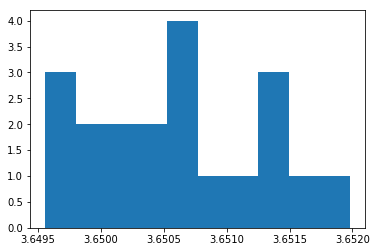

In [474]:
plt.figure()
plt.hist(rmse)

In [460]:
lgb_cv.keys()

dict_keys(['rmse-mean', 'rmse-stdv'])

In [430]:
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=4950)
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train_all,df_train_all['outliers'].values)):
    

In [431]:
folds.split(df_train,df_train['outliers'].values)

<generator object _BaseKFold.split at 0x000002F287C3BD58>

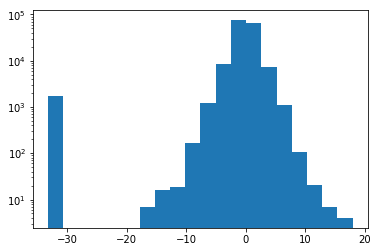

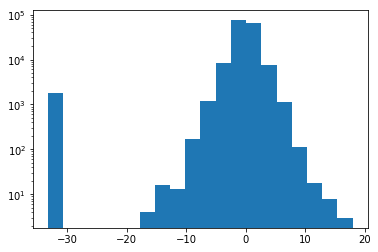

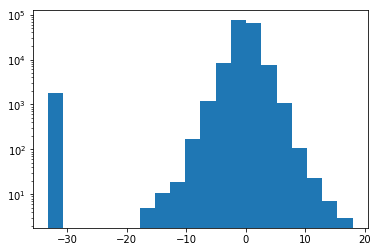

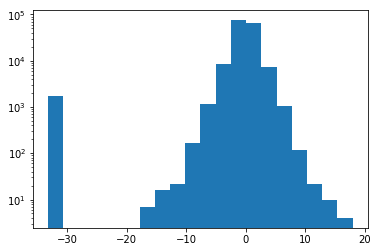

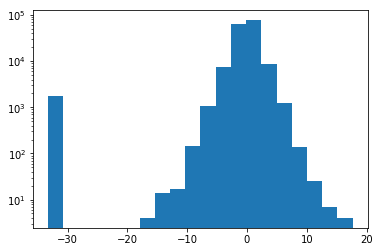

In [440]:
# it seems all folds have same distributions
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4950)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train_all,df_train_all['outliers'].values)):
    plt.figure()
    plt.hist(df_train_all.iloc[trn_idx]['target'],bins=20)
    plt.yscale('log')

#    print("fold {}".format(fold_))
#     trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
#     val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

#         trn_data = lgb.Dataset(df.iloc[trn_idx][train_features], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
#         val_data = lgb.Dataset(df.iloc[val_idx][train_features], label=target.iloc[val_idx])
    
#         num_round = 10000
#         clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data],verbose_eval=0, early_stopping_rounds = 100)
#         oof[val_idx] = clf.predict(df.iloc[val_idx][train_features], num_iteration=clf.best_iteration)
    

In [442]:
from sklearn.model_selection import KFold


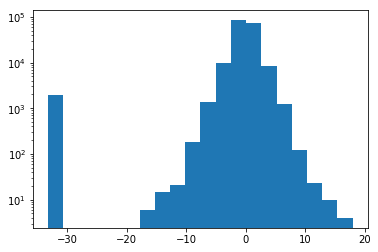

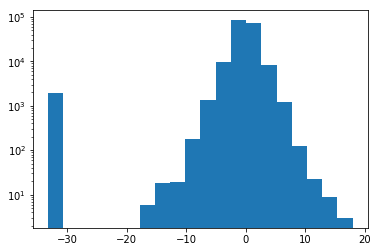

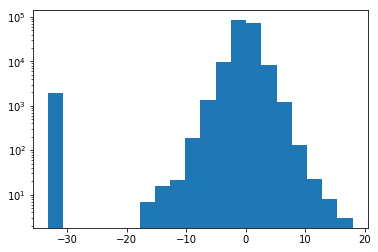

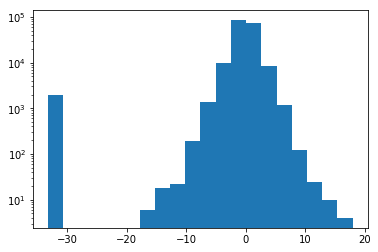

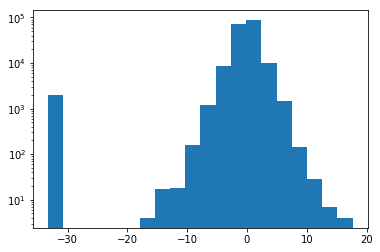

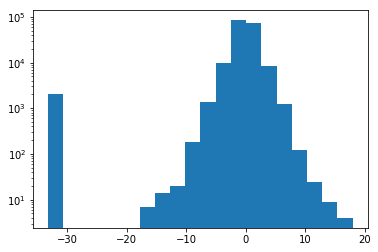

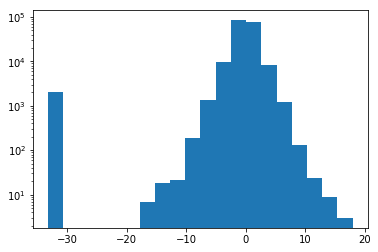

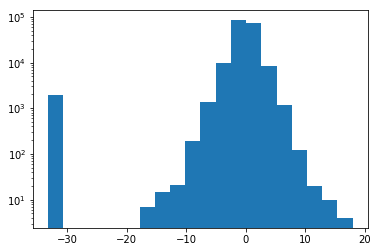

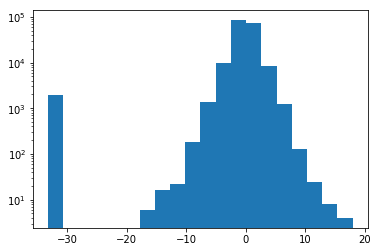

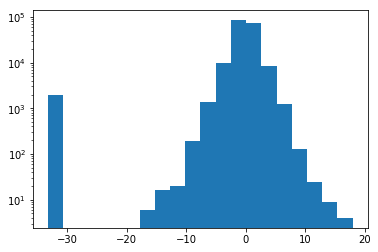

In [446]:
# it seems all have same distributions
folds = KFold(n_splits=10, shuffle=True, random_state=4950)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train_all)):
    plt.figure()
    plt.hist(df_train_all.iloc[trn_idx]['target'],bins=20)
    plt.yscale('log')
    plt.show()

### Let's try to use stacking with predictions with and without outliers

In [475]:
from sklearn.linear_model import BayesianRidge

In [497]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RepeatedKFold

In [476]:
?BayesianRidge

In [480]:
len(feats1)

253

In [482]:
df_train_all.shape

(201917, 263)

In [483]:
df_test_all.shape

(123623, 261)

In [491]:
def regression_final3(train,test,features, to_all=False):
    rg_param = {
             'num_leaves': 31,
             'min_data_in_leaf': 20,
             'objective':'regression',
             'max_depth': -1,
             'learning_rate': 0.01,
             "boosting": "gbdt",
             "feature_fraction": 0.9,
             "bagging_freq": 1,
             "bagging_fraction": 0.9,
             "metric": 'rmse',
             "lambda_l1": 0.1,
             "verbosity": -1,
             "nthread": 6,
    }
    tr_data = lgb.Dataset(train[features], label=train.target)
    cv_score = lgb.cv(rg_param, tr_data, 10000, early_stopping_rounds=600, verbose_eval=200, stratified=False,nfold=10)
    # let's train more
    clf = lgb.train(rg_param, tr_data, num_boost_round=len(cv_score['rmse-mean']), valid_sets=(tr_data), verbose_eval=200)
    
    print('best num: ', len(cv_score['rmse-mean']), '\nbest score:', cv_score['rmse-mean'][-1])
    if to_all==False:
        return clf.predict(train[features]),clf.predict(test[features])
    else:
        return clf.predict(df_train_all[features]),clf.predict(test[features])

In [484]:
oof,prediction=regression_final3(df_train_all,df_test_all,feats1) # predictions with outliers

[200]	cv_agg's rmse: 3.68111 + 0.055984
[400]	cv_agg's rmse: 3.66117 + 0.0551649
[600]	cv_agg's rmse: 3.65373 + 0.0543165
[800]	cv_agg's rmse: 3.65077 + 0.0539272
[1000]	cv_agg's rmse: 3.64921 + 0.0537684
[1200]	cv_agg's rmse: 3.64849 + 0.0536323
[1400]	cv_agg's rmse: 3.64829 + 0.0536221
[1600]	cv_agg's rmse: 3.64801 + 0.0536119
[1800]	cv_agg's rmse: 3.6482 + 0.0536325
[2000]	cv_agg's rmse: 3.64822 + 0.0536338
[200]	training's rmse: 3.56734
[400]	training's rmse: 3.47332
[600]	training's rmse: 3.41097
[800]	training's rmse: 3.36381
[1000]	training's rmse: 3.32346
[1200]	training's rmse: 3.28471
[1400]	training's rmse: 3.25146
best num:  1506 
best score: 3.6478949332344923


In [492]:
oof_lgb,prediction_lgb=regression_final3(df_train_all[df_train_all.outliers==0],df_test_all,feats1,to_all=True) # predictions without outliers

[200]	cv_agg's rmse: 1.58197 + 0.0112056
[400]	cv_agg's rmse: 1.56528 + 0.010904
[600]	cv_agg's rmse: 1.55952 + 0.0108467
[800]	cv_agg's rmse: 1.55706 + 0.0108151
[1000]	cv_agg's rmse: 1.55593 + 0.0108739
[1200]	cv_agg's rmse: 1.55531 + 0.0108853
[1400]	cv_agg's rmse: 1.55495 + 0.0108793
[1600]	cv_agg's rmse: 1.5547 + 0.010896
[1800]	cv_agg's rmse: 1.55448 + 0.0109344
[2000]	cv_agg's rmse: 1.55428 + 0.010909
[2200]	cv_agg's rmse: 1.55417 + 0.010903
[2400]	cv_agg's rmse: 1.55409 + 0.0110059
[2600]	cv_agg's rmse: 1.55408 + 0.0110172
[2800]	cv_agg's rmse: 1.55405 + 0.0110081
[3000]	cv_agg's rmse: 1.55404 + 0.0109891
[3200]	cv_agg's rmse: 1.55402 + 0.0110086
[3400]	cv_agg's rmse: 1.55401 + 0.0110013
[3600]	cv_agg's rmse: 1.55404 + 0.0110217
[3800]	cv_agg's rmse: 1.55406 + 0.0110325
[200]	training's rmse: 1.57387
[400]	training's rmse: 1.54889
[600]	training's rmse: 1.53457
[800]	training's rmse: 1.52389
[1000]	training's rmse: 1.51471
[1200]	training's rmse: 1.5066
[1400]	training's rmse: 

In [493]:
target=df_train_all.target

In [498]:
train_stack = np.vstack([oof,oof_lgb]).transpose() # prediction for train set
test_stack = np.vstack([prediction,prediction_lgb]).transpose() # predictions for test set

folds = RepeatedKFold(n_splits=5,n_repeats=1,random_state=4520)
oof_stack = np.zeros(train_stack.shape[0])
predictions_stack = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_stack, target)):
    print("fold n°{}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values

    print("-" * 10 + "Stacking " + str(fold_) + "-" * 10)
#     cb_model = CatBoostRegressor(iterations=3000, learning_rate=0.1, depth=8, l2_leaf_reg=20, bootstrap_type='Bernoulli',  eval_metric='RMSE', metric_period=50, od_type='Iter', od_wait=45, random_seed=17, allow_writing_files=False)
#     cb_model.fit(trn_data, trn_y, eval_set=(val_data, val_y), cat_features=[], use_best_model=True, verbose=True)
    clf = BayesianRidge()
    clf.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf.predict(val_data)
    predictions_stack += clf.predict(test_stack) / 5


np.sqrt(mean_squared_error(target.values, oof_stack))

fold n°0
----------Stacking 0----------
fold n°1
----------Stacking 1----------
fold n°2
----------Stacking 2----------
fold n°3
----------Stacking 3----------
fold n°4
----------Stacking 4----------


3.0990527443708045

In [504]:
predictions_stack[predictions_stack<-30]

array([-33.06363179, -30.20757726, -41.53762298, -33.8112687 ,
       -38.94699494, -33.69881097, -32.09767656, -30.6962599 ,
       -31.51950558, -33.13778017, -36.10921649, -31.79693176,
       -39.35780448, -40.65217028, -34.79360042, -41.66881431,
       -31.38528052, -35.47464297, -32.3567514 ])

In [490]:
oof_lgb.shape

(199710,)

In [538]:
test.shape

(123623, 5)

In [543]:
df=pd.DataFrame()
df['card_id']=test.card_id
df['target']=predictions_stack
df.to_csv('bayes_stacking_with_without_outliers.csv',index=False)
# LB:3.739

,card_id,target
0,C_ID_0ab67a22ab,-4.098353
1,C_ID_130fd0cbdd,-0.138517
2,C_ID_b709037bc5,-1.529189
3,C_ID_d27d835a9f,0.054889
4,C_ID_2b5e3df5c2,-1.844396
5,C_ID_5814b4f13c,0.122646
6,C_ID_a1b3c75277,0.517626
7,C_ID_f7cada36d3,0.864906
8,C_ID_9d2bc8dfc4,-1.052234
9,C_ID_6d8dba8475,-1.721192


In [510]:
predictions_stack2=predictions_stack.copy()

In [511]:
predictions_stack2[predictions_stack<-33.21928095]=-33.21928095

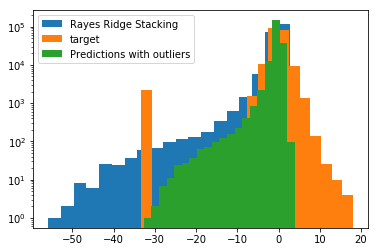

In [522]:
plt.figure()
plt.hist(oof_stack,bins=20,label='Rayes Ridge Stacking')
plt.hist(target,bins=20, label='target')
plt.hist(oof,bins=20,label='Predictions with outliers')
#plt.hist(target,bins=20, label='target')


plt.yscale('log')
plt.legend()

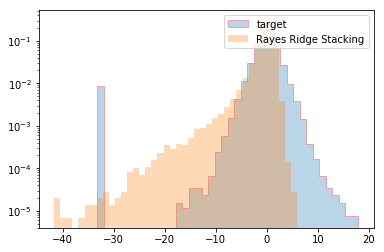

In [531]:
plt.figure()
kwargs = dict(histtype='stepfilled', alpha=0.3, normed=True, bins=40)
plt.hist(target,label='target',**kwargs,edgecolor='r')
plt.hist(predictions_stack,label='Rayes Ridge Stacking',**kwargs)
#plt.hist(target,label='target',**kwargs)

plt.yscale('log')
plt.legend()

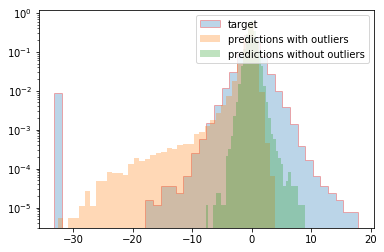

In [530]:
plt.figure()
kwargs = dict(histtype='stepfilled', alpha=0.3, normed=True, bins=40)

plt.hist(target,label='target',**kwargs,edgecolor='r')
plt.hist(oof,label='predictions with outliers',**kwargs)
plt.hist(oof_lgb,label='predictions without outliers',**kwargs)

plt.yscale('log')
plt.legend()

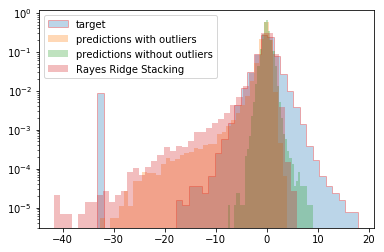

In [532]:
plt.figure()
kwargs = dict(histtype='stepfilled', alpha=0.3, normed=True, bins=40)

plt.hist(target,label='target',**kwargs,edgecolor='r')
plt.hist(oof,label='predictions with outliers',**kwargs)
plt.hist(oof_lgb,label='predictions without outliers',**kwargs)
plt.hist(predictions_stack,label='Rayes Ridge Stacking',**kwargs)

plt.yscale('log')
plt.legend()